# CGAN
Convolutional Generational Adversarial Model recreated from the paper 'Unsupervised representation learning with conv Gan' and further augmented with the insight of the following paper 'NIPS 2016 Tutorial: Generative Adversarial Networks'.

## Data Preprocessing
The MNIST dataset is chosen to test this first model.


In [0]:
# Imports
from tensorflow.keras.datasets import mnist
import numpy as np


In [0]:
# Data hyperparameters
img_width = 28
img_height = 28
img_channels = 1

img_shape = (img_width, img_height, img_channels)

In [0]:
# MNIST dataset images loading
(x_train, _), _ = mnist.load_data()

# Dataset reshaping
x_train = x_train.reshape(-1, img_height, img_width, img_channels).astype(np.float32)

# Dataset normalization into the Tanh function output range ([-1, 1])
x_train = 2.*(x_train - np.min(x_train))/np.ptp(x_train)-1

## Model Instatiation

In [0]:
# Imports
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose
from tensorflow.keras.layers import Activation, LeakyReLU
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.activations import relu, tanh
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.optimizers import Adam

In [0]:
# Model hyperparameters
# Common
conv_kernel_size = 5
dropout_rate = 0.4
norm_momentum = 0.9
optimizer_momentum = 0.5
learning_rate = 0.0002
lrelu_alpha = 0.2

# Generator
gen_depth = 256

# Discriminator
dis_depth = 32


### Generator

The number of Transposed Convolutional layers have been reduced from four to two in order to match the size of the images of the MNIST dataset.

In [0]:
def generator_model():
  G = Sequential()

  G.add(Dense(7*7*gen_depth, input_dim=(100)))
  G.add(BatchNormalization(momentum=norm_momentum))
  G.add(LeakyReLU(alpha=lrelu_alpha))

  # Project and Reshape
  G.add(Reshape((7, 7, gen_depth)))
  G.add(Dropout(dropout_rate))
  
  # CONV 1
  G.add(Conv2DTranspose(gen_depth//2, kernel_size=conv_kernel_size, strides=2, padding="same"))
  G.add(BatchNormalization(momentum=norm_momentum))
  G.add(LeakyReLU(alpha=lrelu_alpha))

  # CONV 2      
  G.add(Conv2DTranspose(img_channels, kernel_size=conv_kernel_size, strides=2, padding="same"))
  G.add(Activation('tanh'))
  
  return G

In [7]:
G = generator_model()
G.summary()

W0709 16:54:09.551507 139679670409088 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1266944   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 14, 14, 128)       5

### Discriminator
Although characteristics for the discriminator model where explicity recommended in the paper, there is no specific architecture to follow. 

In that matter, the model have been resolved into simple convolutional classification, following, of course, the characteristics stated.

Something important to be noted is that the model deviates from the pape's recommendations from not having batch normalization in all of its layers excepting the input one. Whenever this batch normalization have been used, as much as the discriminator had very good results, the generator was unable to learn to properly produce number images, getting stuck in always generating a random image which was very good at fooling the discriminator.


In [0]:
def discriminator_model():
  D = Sequential()

  D.add(Conv2D(dis_depth, kernel_size=conv_kernel_size, input_shape=img_shape, strides=2, padding='same'))
  D.add(LeakyReLU(alpha=lrelu_alpha))
  D.add(Dropout(dropout_rate))

  D.add(Conv2D(dis_depth*2, kernel_size=conv_kernel_size, strides=2, padding='same'))
  D.add(LeakyReLU(alpha=lrelu_alpha))
  D.add(Dropout(dropout_rate))

  D.add(Conv2D(dis_depth*4, kernel_size=conv_kernel_size, strides=2, padding='same'))
  D.add(LeakyReLU(alpha=lrelu_alpha))
  D.add(Dropout(dropout_rate))

  D.add(Conv2D(dis_depth*8, kernel_size=conv_kernel_size, strides=1, padding='same'))
  D.add(LeakyReLU(alpha=lrelu_alpha))
  D.add(Dropout(dropout_rate))

  D.add(Flatten())
  D.add(Dense(1))
  D.add(Activation('sigmoid'))
  
  return D

In [9]:
D = discriminator_model()
D.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        832       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 64)          51264     
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)        

## Models

In [10]:
Discriminator = Sequential()

Discriminator.add(D)
Discriminator.compile(loss='binary_crossentropy', 
                      optimizer=Adam(lr=learning_rate, beta_1=0.5),
                      metrics = ['accuracy'])

W0709 16:54:10.224815 139679670409088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
Adversarial = Sequential()

Adversarial.add(G)
Adversarial.add(D)
Adversarial.compile(loss='binary_crossentropy', 
                    optimizer=Adam(lr=learning_rate, beta_1=optimizer_momentum),
                    metrics = ['accuracy'])

In [0]:
Generator = G

## Training

In [0]:
# Section imports
import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
# Training hyperparamenters
train_steps = 50000
generator_training_interval = 5
discriminator_training_interval = 1
batch_size = 128
print_output_interval = 500

In [0]:
def plot_images(save_img=False,
                fake=True, 
                samples=16, 
                noise=None, 
                step=0,
                filename='generation  ' + str(datetime.datetime.now()) + '.png'):
  
  if fake:
    if noise is None:
      noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
      
    images = Generator.predict(noise)
    
  else:
    i = np.random.randint(0, x_train.shape[0], samples)
    images = x_train[i, :, :, :]

  plt.figure(figsize=(10,10))
  
  for i in range(images.shape[0]):
    plt.subplot(4, 4, i+1)
    image = images[i, :, :, :]
    image = np.reshape(image, [img_height, img_width])
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
  plt.tight_layout()
  
  if save_img:
    plt.savefig(filename)
    plt.close('all')
    
  else:
    plt.show()

In [0]:
def train_generator(Adversarial, batch_size):
  y = np.ones([batch_size, 1])
  noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
  
  a_loss = Adversarial.train_on_batch(noise, y)
  
  return a_loss

In [0]:
def train_discriminator(Discriminator, Generator, x_train, batch_size):
  images_train = x_train[np.random.randint(0, x_train.shape[0], size=batch_size), :, :, :]
  noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
  images_fake = Generator.predict(noise)
  
  x = np.concatenate((images_train, images_fake))
  y = np.ones([2*batch_size, 1])
  y[batch_size:, :] = 0
  
  d_loss = Discriminator.train_on_batch(x, y)
  
  return d_loss

499: [D loss: 0.019635, acc: 0.996094]  [A loss: 3.699217, acc: 0.000000]


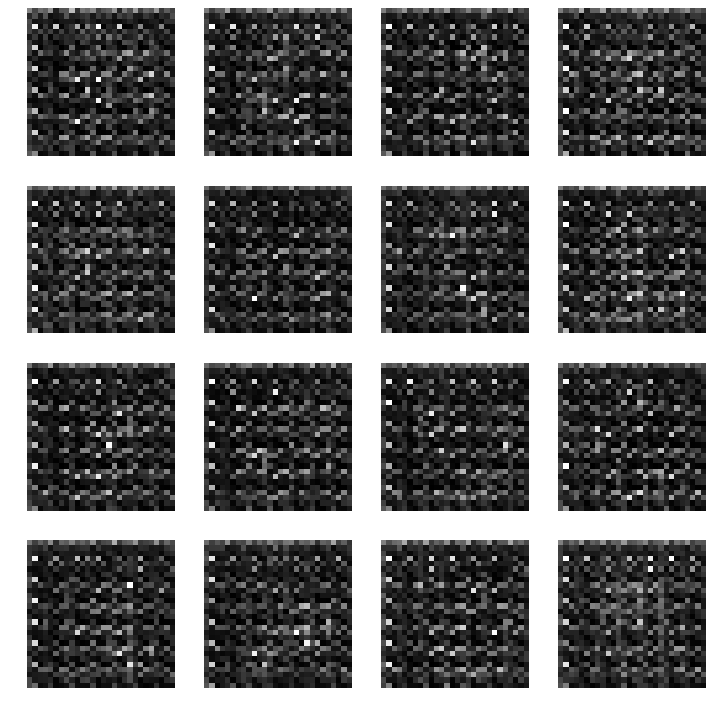

999: [D loss: 0.105723, acc: 0.953125]  [A loss: 5.247954, acc: 0.000000]


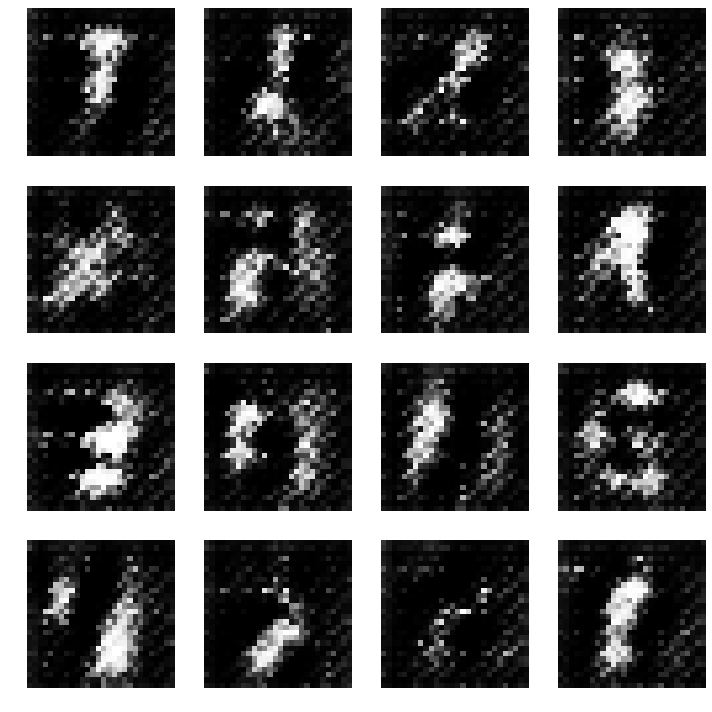

1499: [D loss: 0.204993, acc: 0.933594]  [A loss: 2.498247, acc: 0.132812]


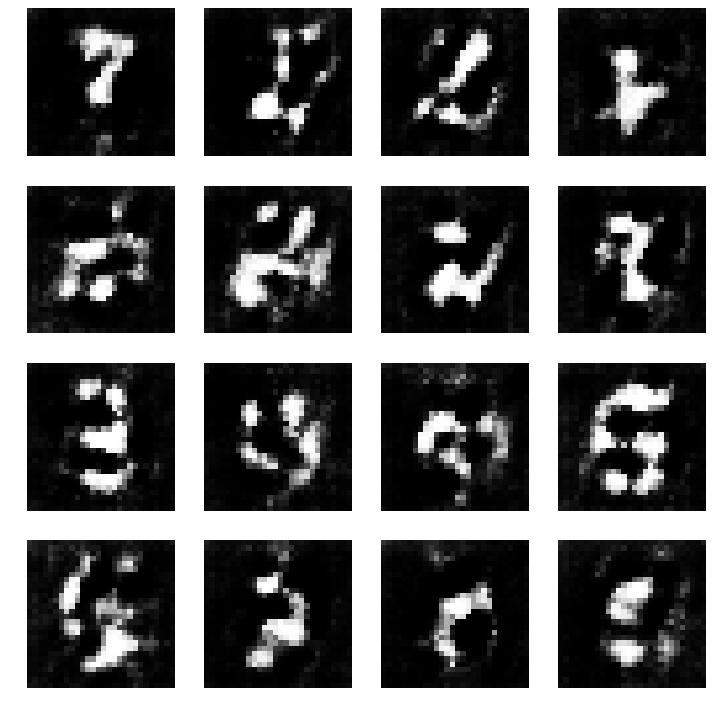

1999: [D loss: 0.390266, acc: 0.796875]  [A loss: 2.236401, acc: 0.148438]


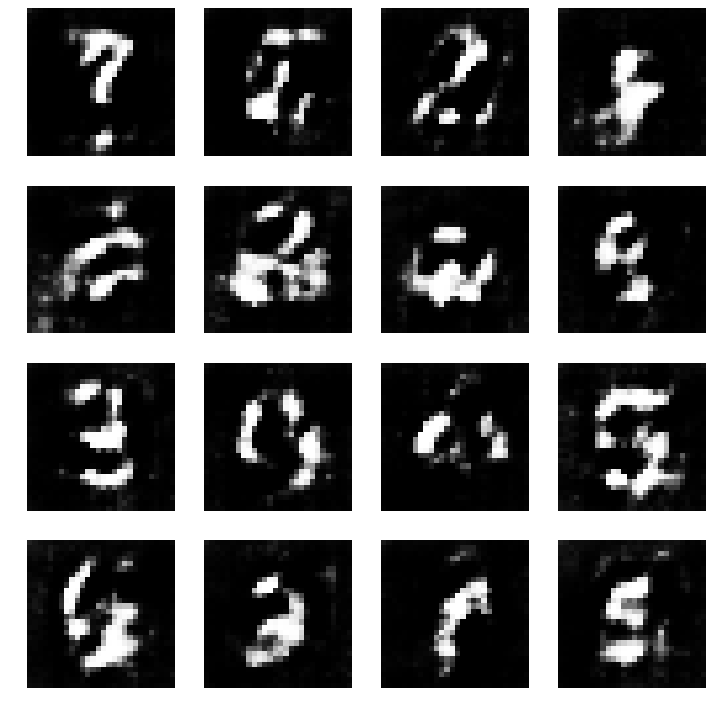

2499: [D loss: 0.309157, acc: 0.890625]  [A loss: 2.238528, acc: 0.140625]


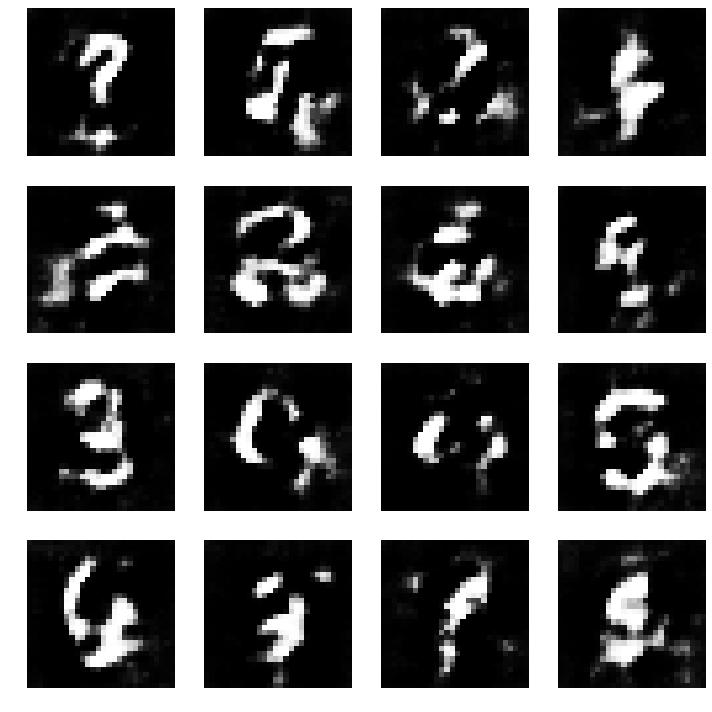

2999: [D loss: 0.357057, acc: 0.843750]  [A loss: 2.452729, acc: 0.109375]


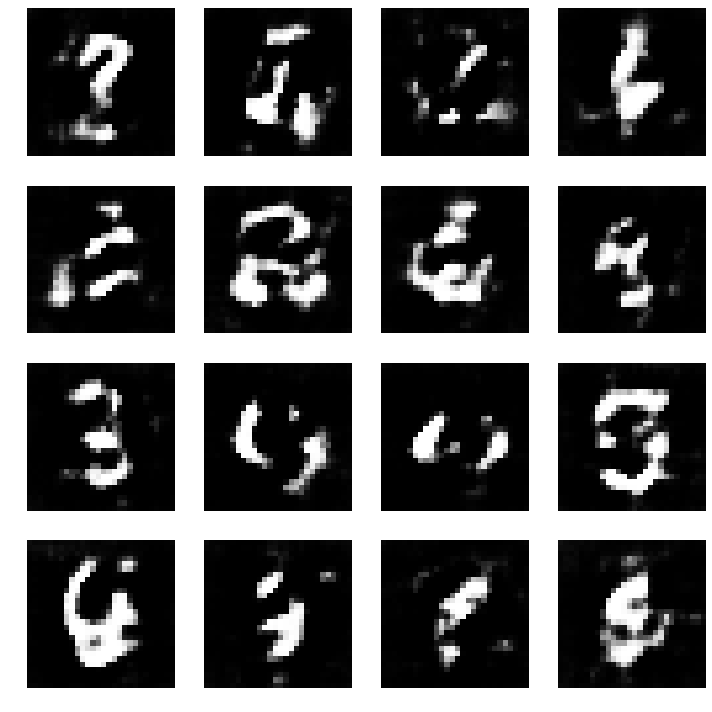

3499: [D loss: 0.272118, acc: 0.875000]  [A loss: 2.638911, acc: 0.156250]


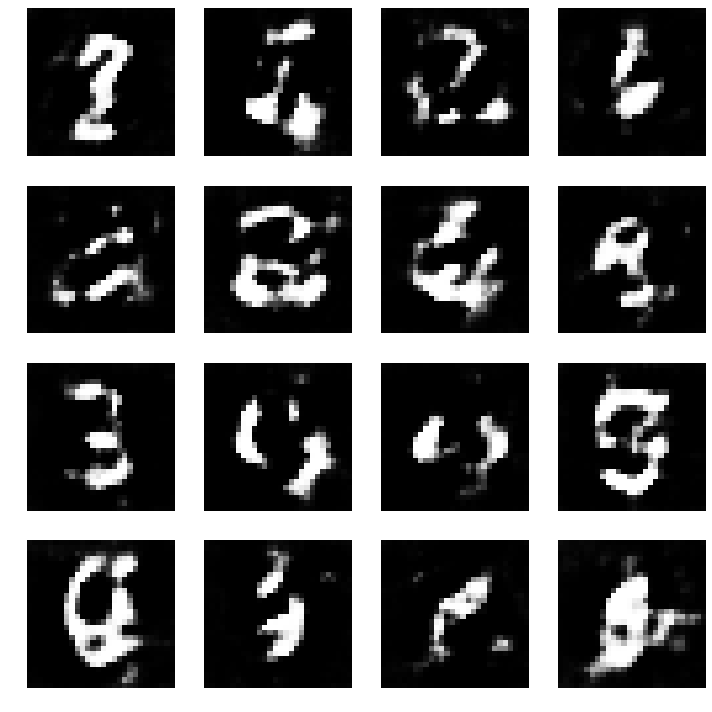

3999: [D loss: 0.256753, acc: 0.875000]  [A loss: 2.446938, acc: 0.132812]


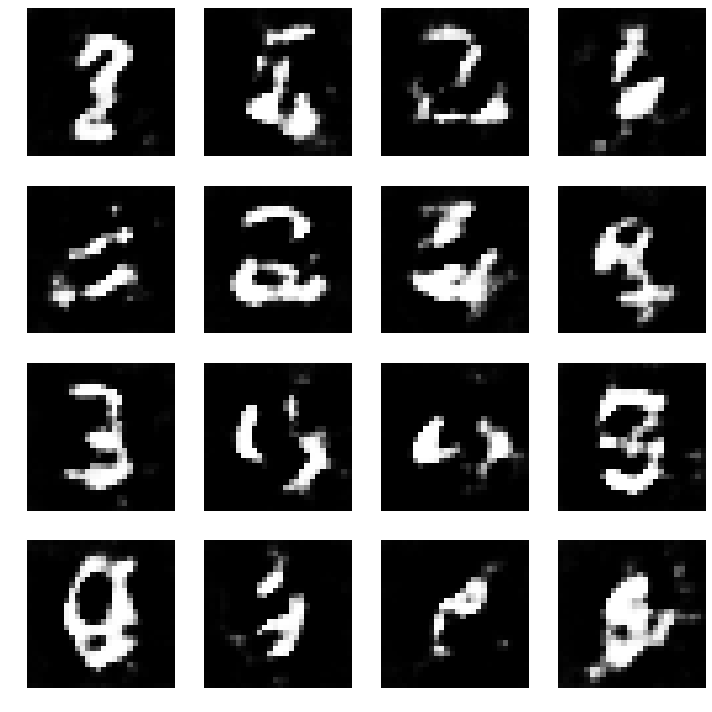

4499: [D loss: 0.314928, acc: 0.867188]  [A loss: 2.685475, acc: 0.101562]


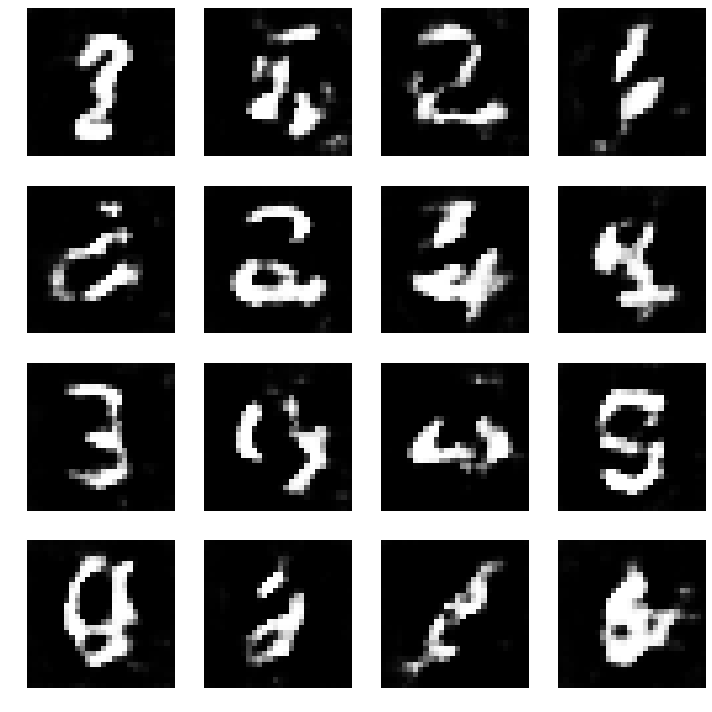

4999: [D loss: 0.290395, acc: 0.890625]  [A loss: 2.774863, acc: 0.070312]


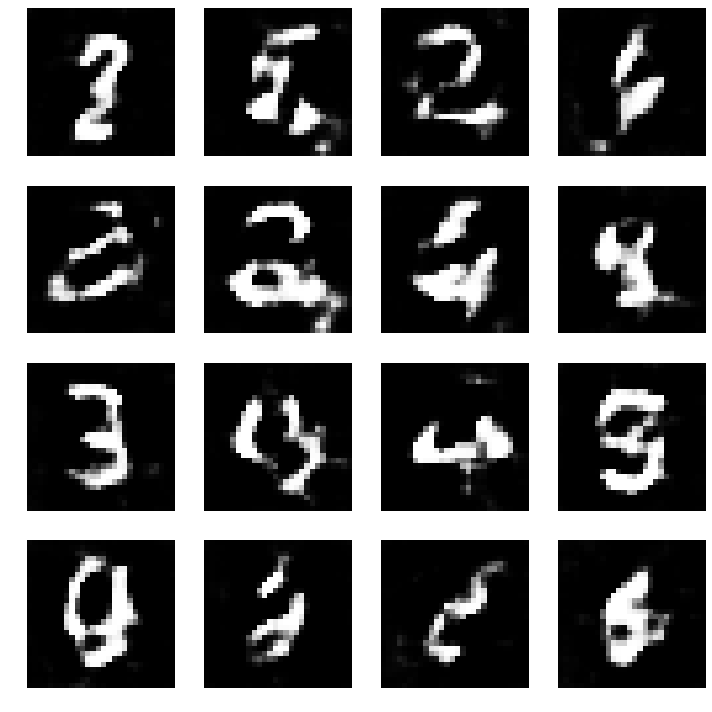

5499: [D loss: 0.315450, acc: 0.835938]  [A loss: 2.448720, acc: 0.078125]


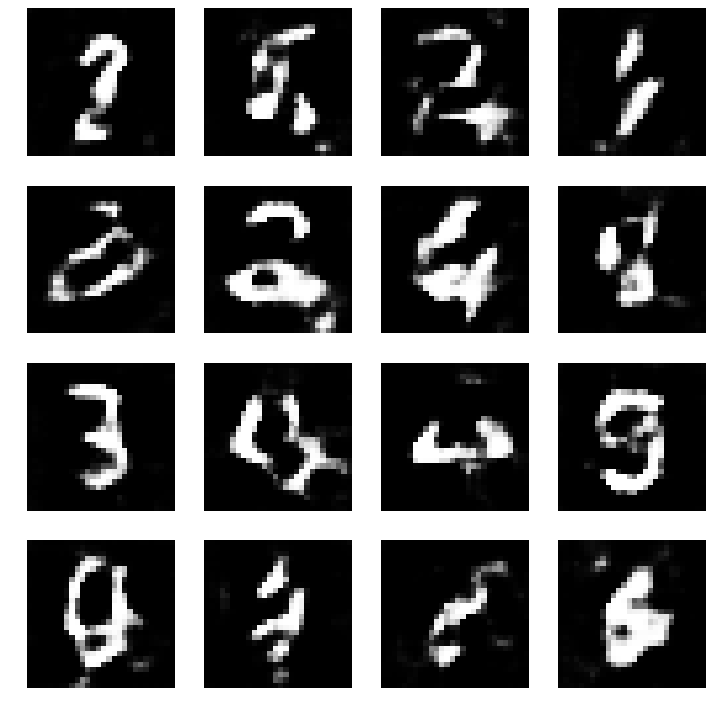

5999: [D loss: 0.237469, acc: 0.925781]  [A loss: 2.780527, acc: 0.101562]


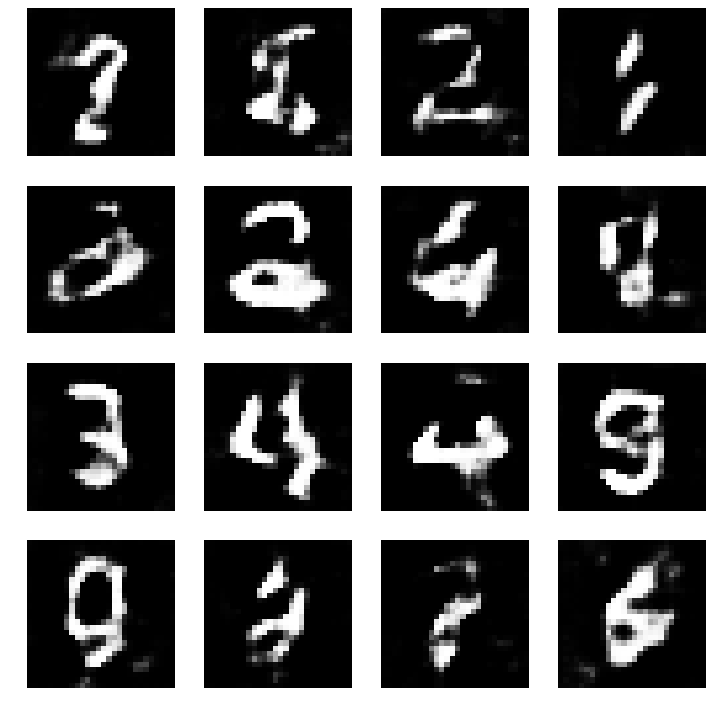

6499: [D loss: 0.290320, acc: 0.875000]  [A loss: 2.420836, acc: 0.132812]


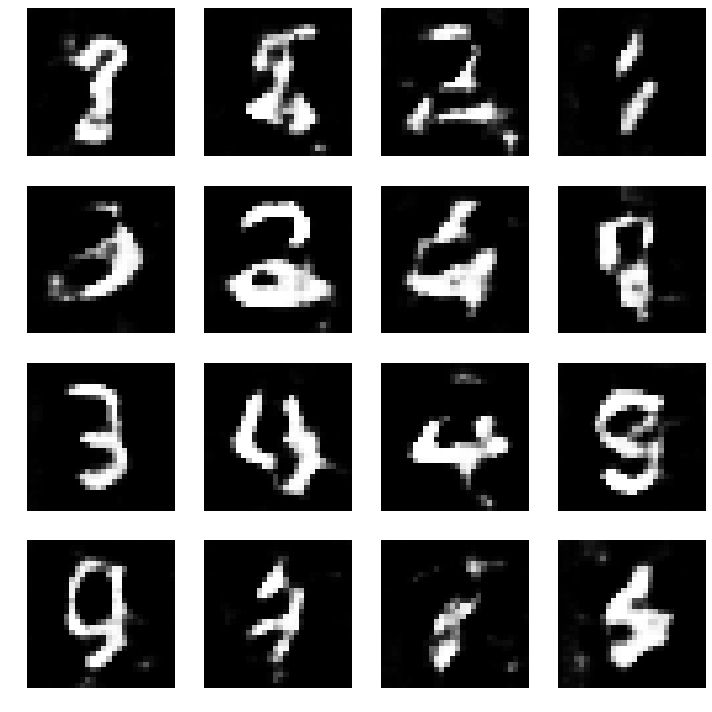

6999: [D loss: 0.279788, acc: 0.898438]  [A loss: 2.471914, acc: 0.109375]


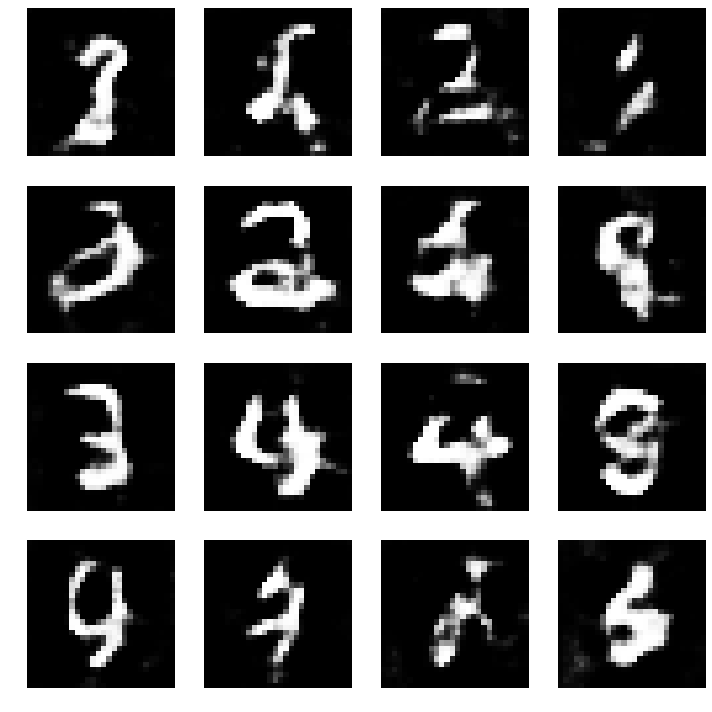

7499: [D loss: 0.379348, acc: 0.835938]  [A loss: 2.301980, acc: 0.109375]


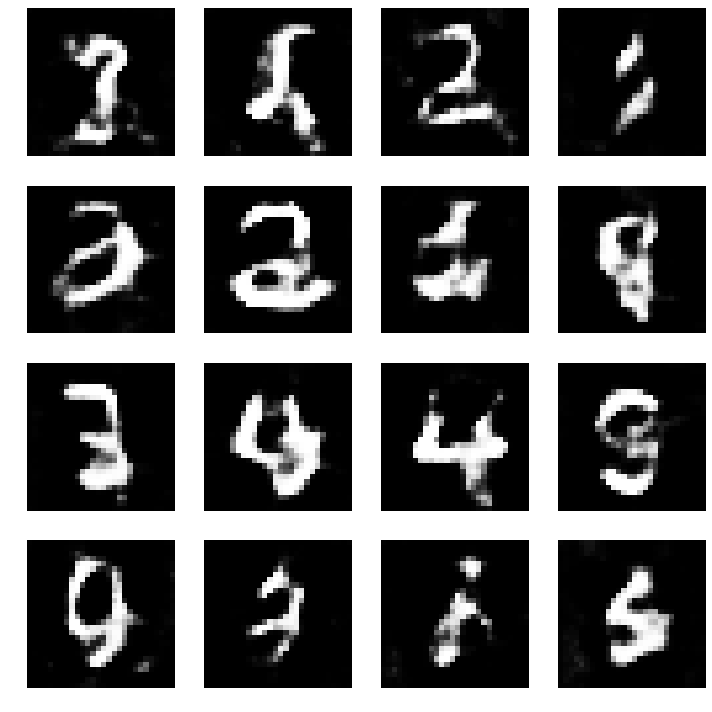

7999: [D loss: 0.319362, acc: 0.851562]  [A loss: 2.202163, acc: 0.117188]


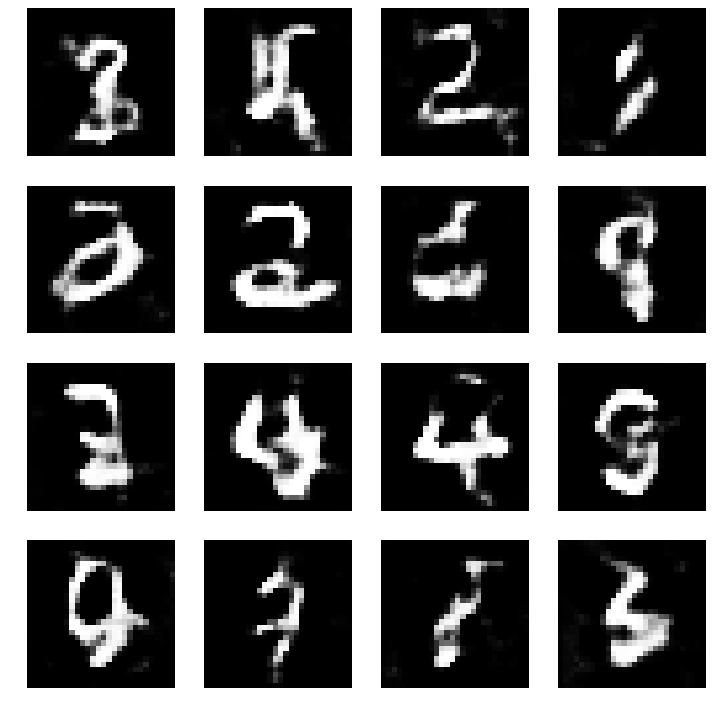

8499: [D loss: 0.317685, acc: 0.859375]  [A loss: 2.091866, acc: 0.171875]


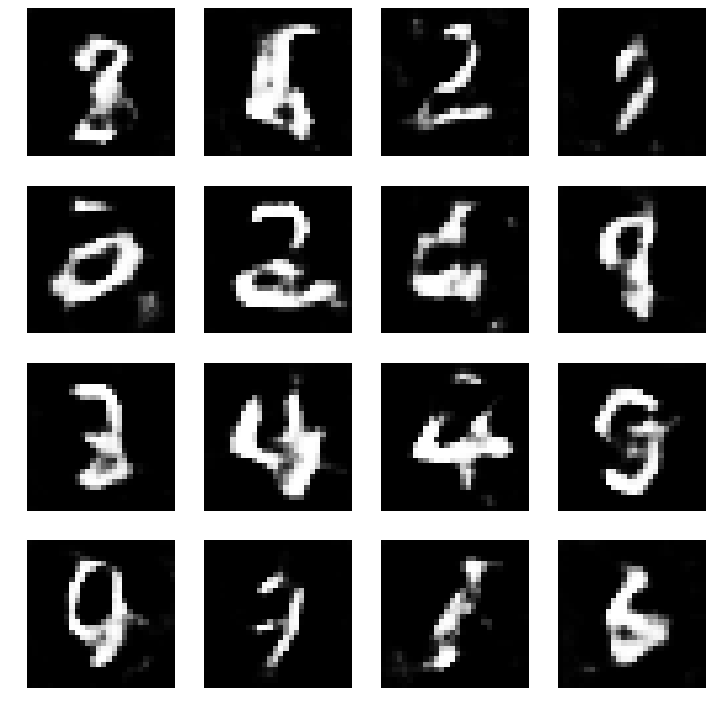

8999: [D loss: 0.389309, acc: 0.824219]  [A loss: 2.098608, acc: 0.171875]


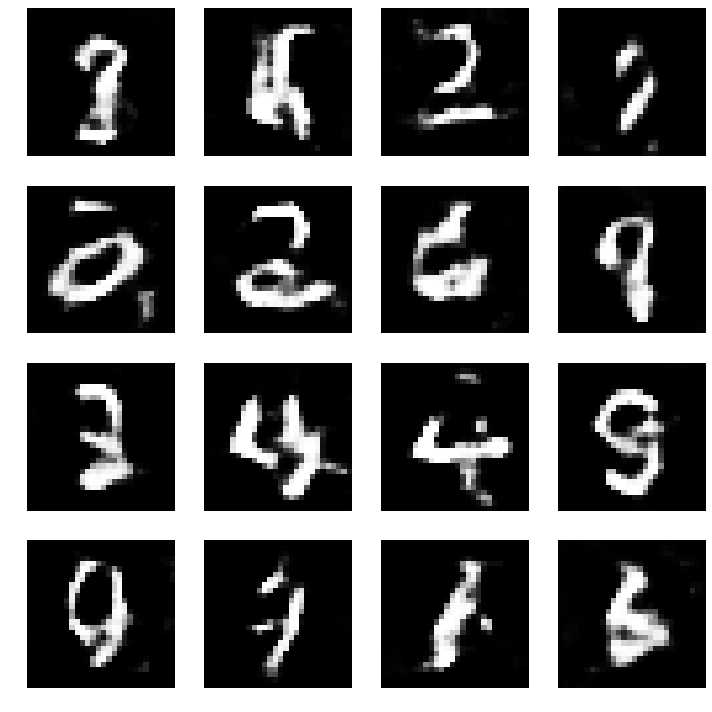

9499: [D loss: 0.408856, acc: 0.816406]  [A loss: 2.445539, acc: 0.078125]


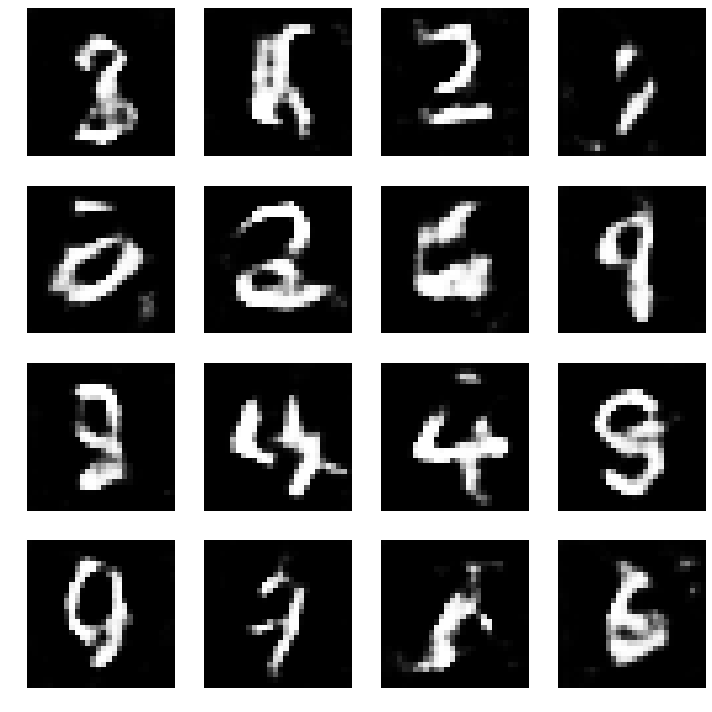

9999: [D loss: 0.338411, acc: 0.871094]  [A loss: 2.390882, acc: 0.101562]


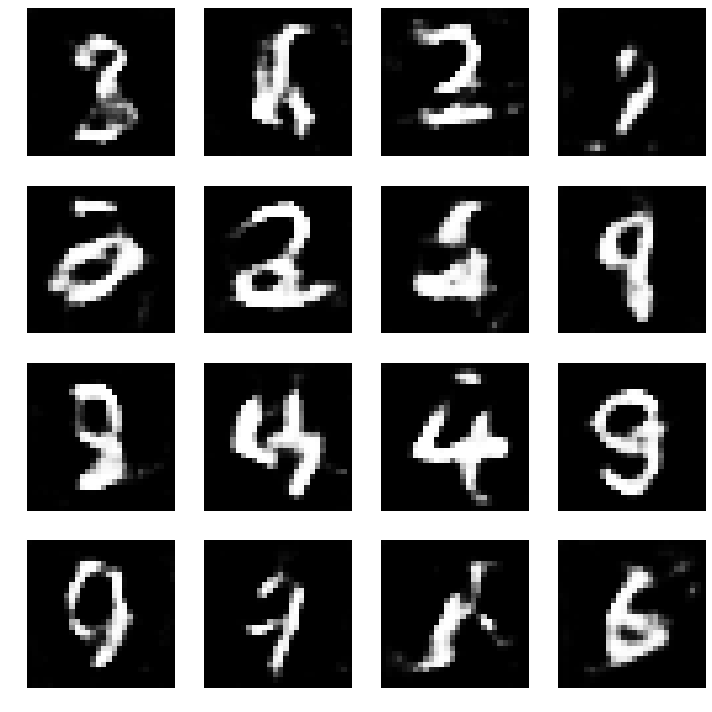

10499: [D loss: 0.454571, acc: 0.808594]  [A loss: 2.102646, acc: 0.117188]


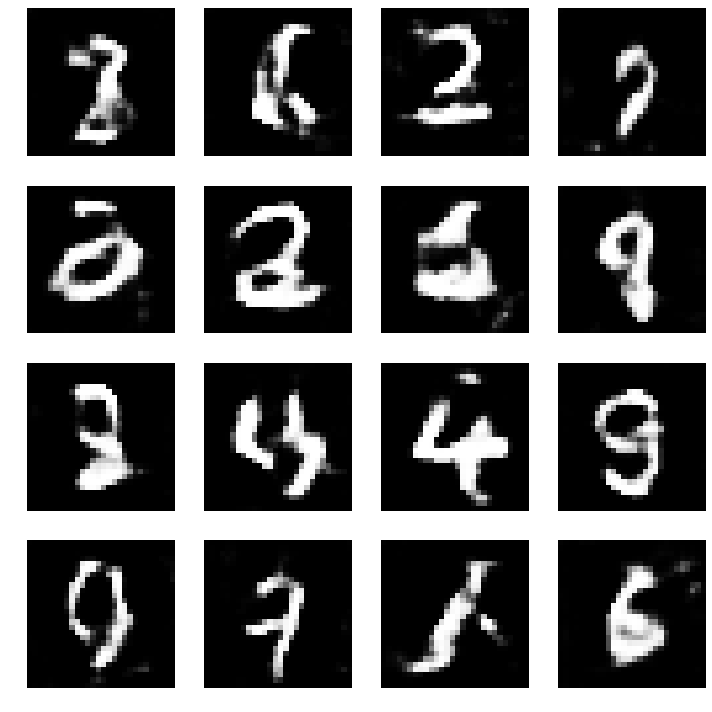

10999: [D loss: 0.393517, acc: 0.812500]  [A loss: 2.177227, acc: 0.132812]


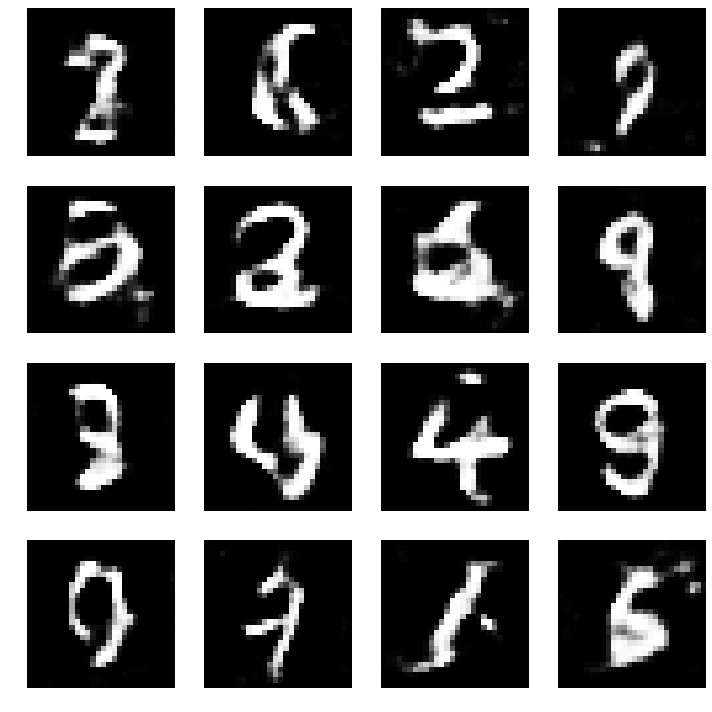

11499: [D loss: 0.346236, acc: 0.851562]  [A loss: 2.328146, acc: 0.101562]


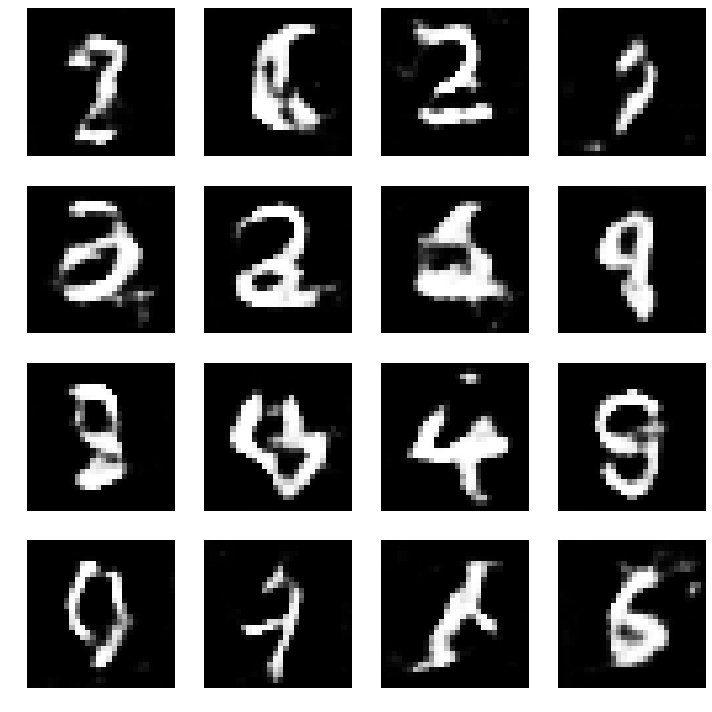

11999: [D loss: 0.371337, acc: 0.828125]  [A loss: 1.884384, acc: 0.109375]


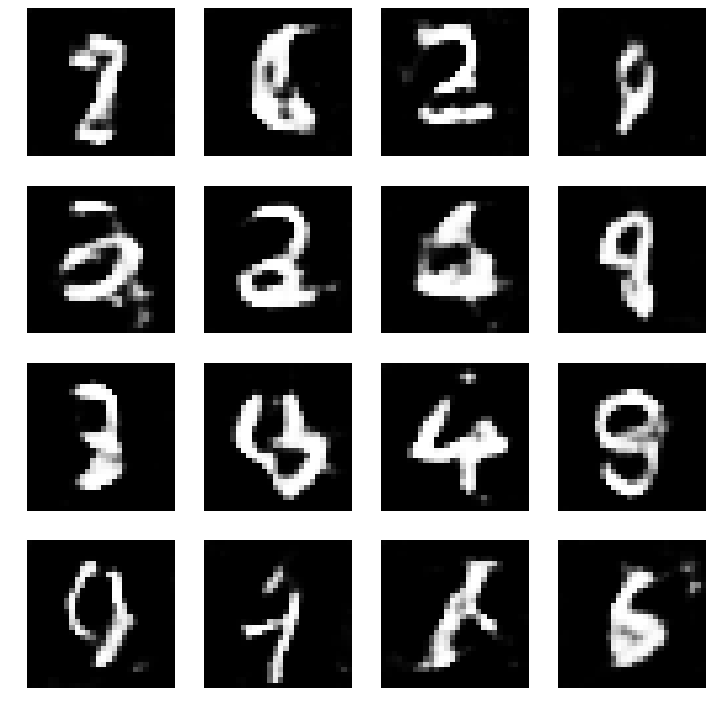

12499: [D loss: 0.399551, acc: 0.816406]  [A loss: 2.213200, acc: 0.101562]


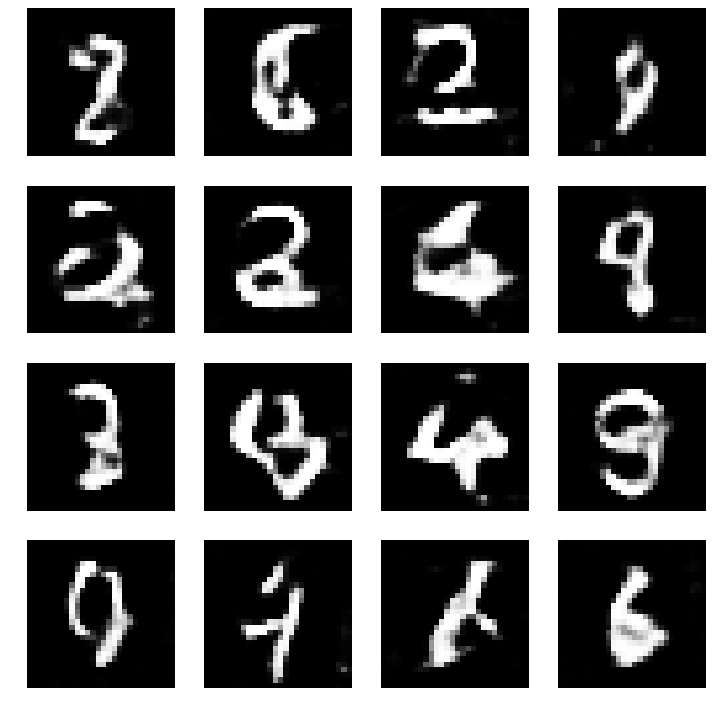

12999: [D loss: 0.372698, acc: 0.808594]  [A loss: 2.151644, acc: 0.156250]


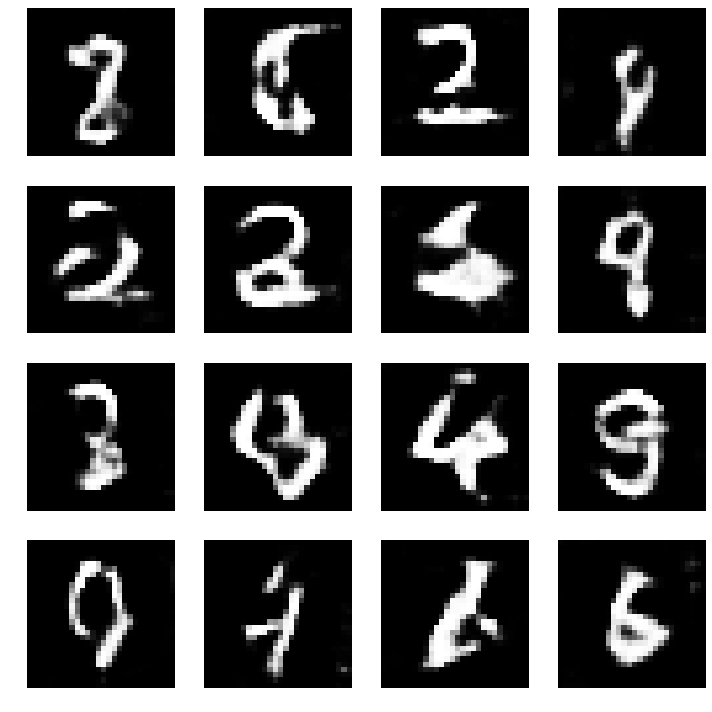

13499: [D loss: 0.349411, acc: 0.843750]  [A loss: 2.354047, acc: 0.085938]


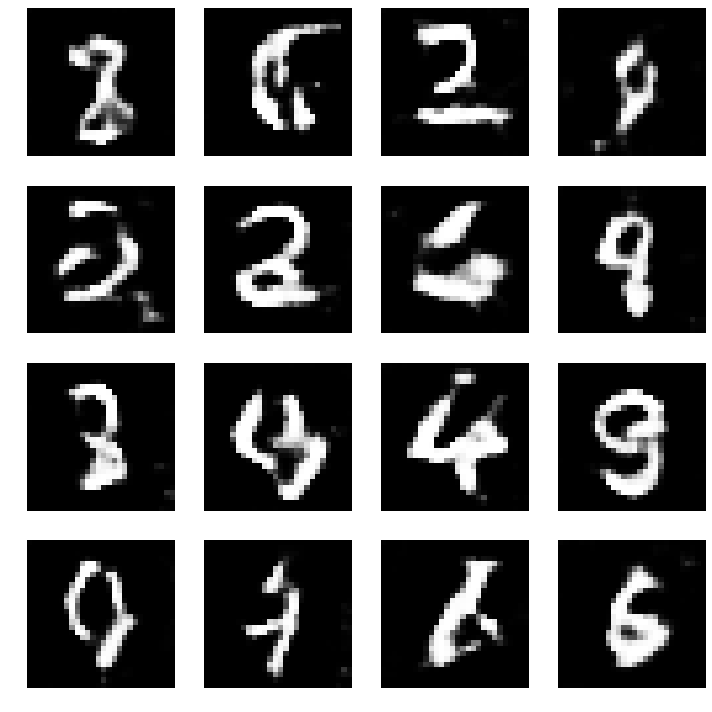

13999: [D loss: 0.356275, acc: 0.839844]  [A loss: 2.296650, acc: 0.117188]


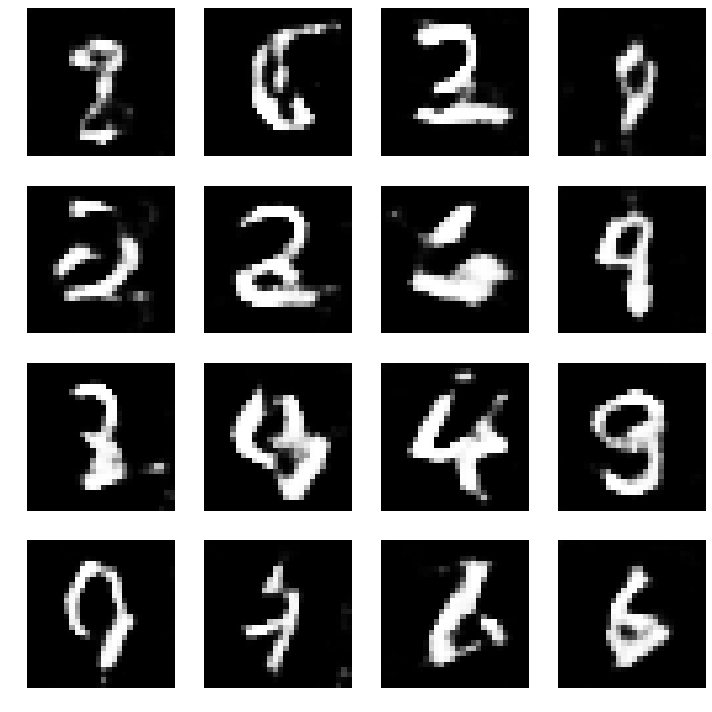

14499: [D loss: 0.353643, acc: 0.839844]  [A loss: 1.633995, acc: 0.195312]


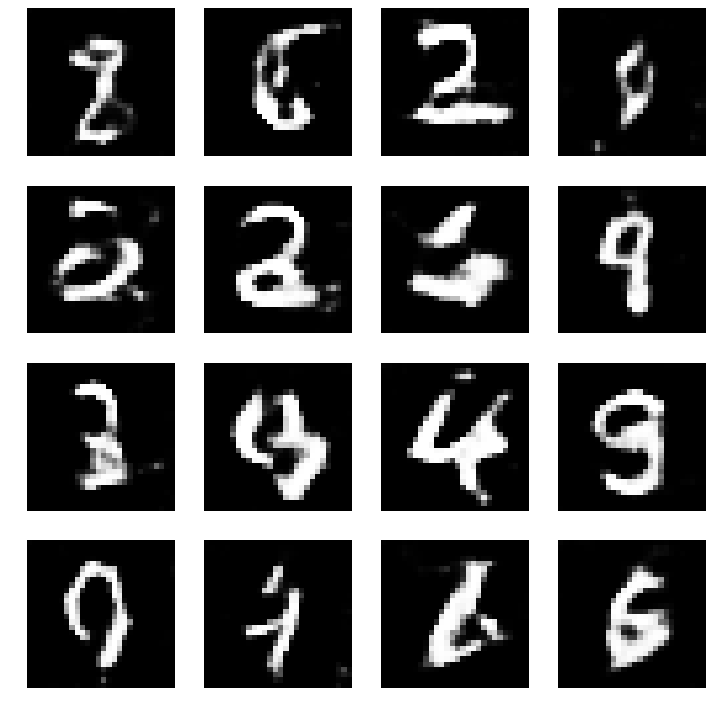

14999: [D loss: 0.434333, acc: 0.816406]  [A loss: 2.163500, acc: 0.085938]


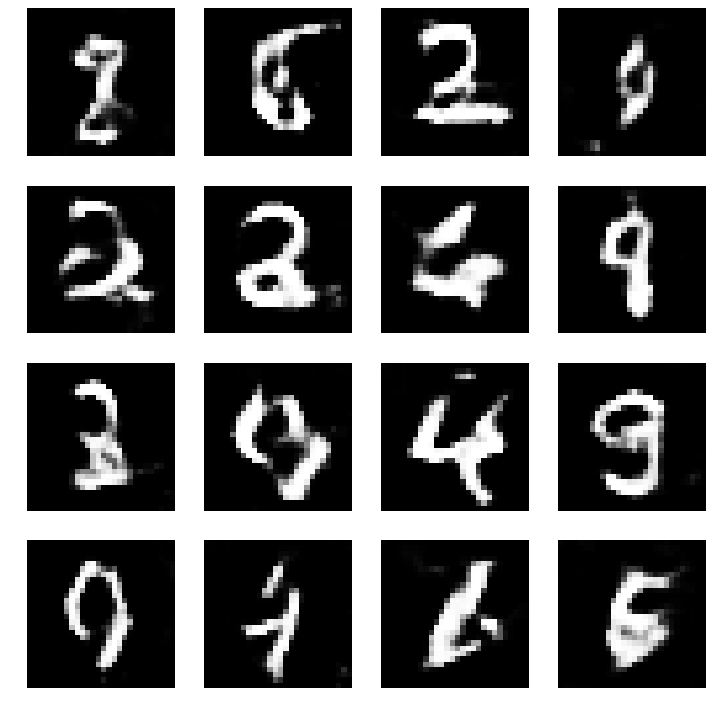

15499: [D loss: 0.386860, acc: 0.812500]  [A loss: 2.028518, acc: 0.148438]


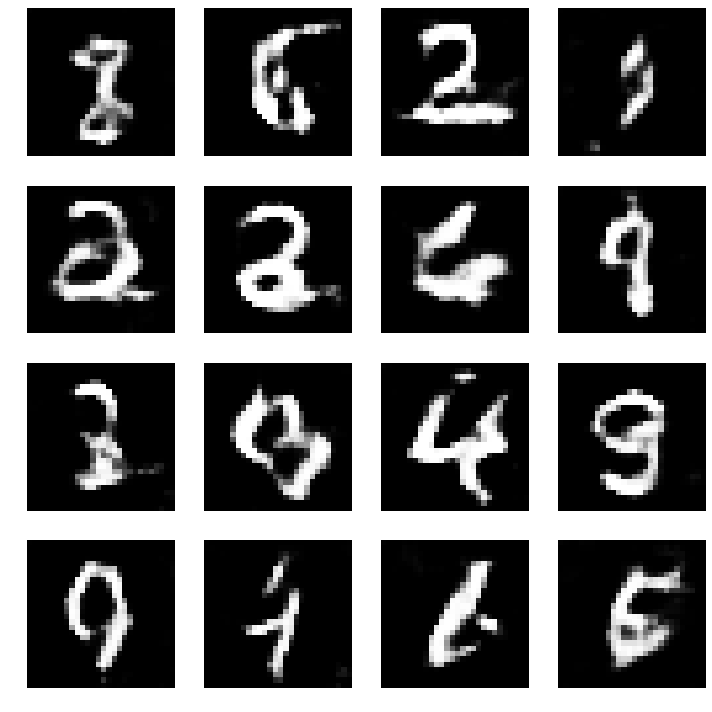

15999: [D loss: 0.465567, acc: 0.761719]  [A loss: 2.235630, acc: 0.109375]


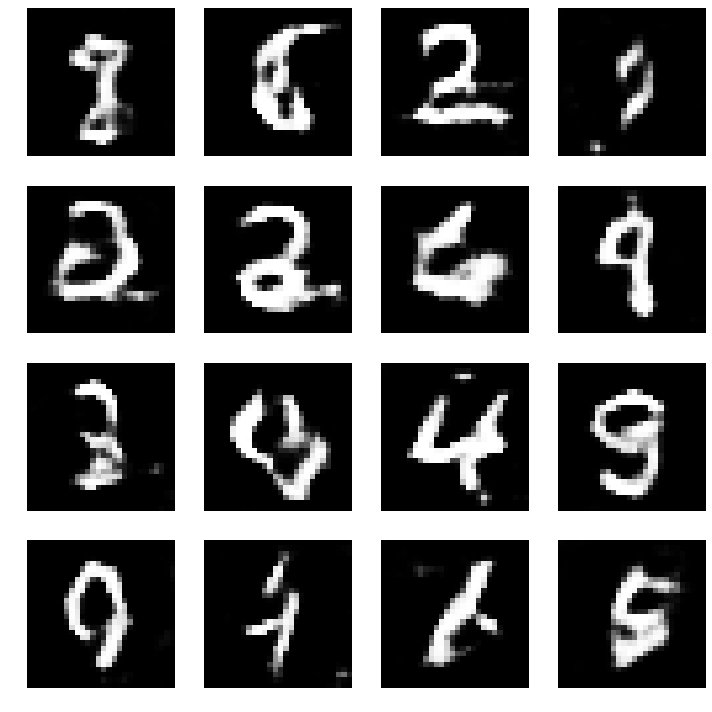

16499: [D loss: 0.325625, acc: 0.863281]  [A loss: 2.293385, acc: 0.125000]


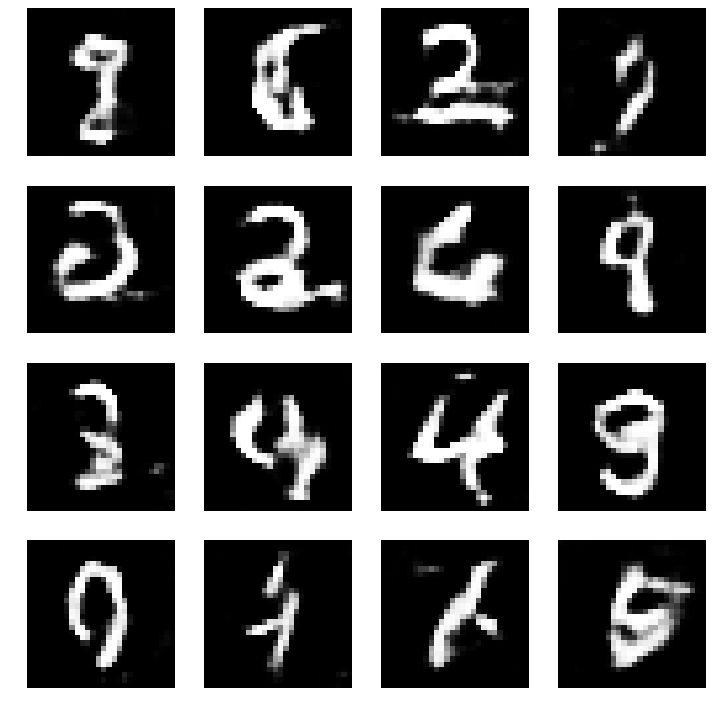

16999: [D loss: 0.441814, acc: 0.820312]  [A loss: 1.956813, acc: 0.148438]


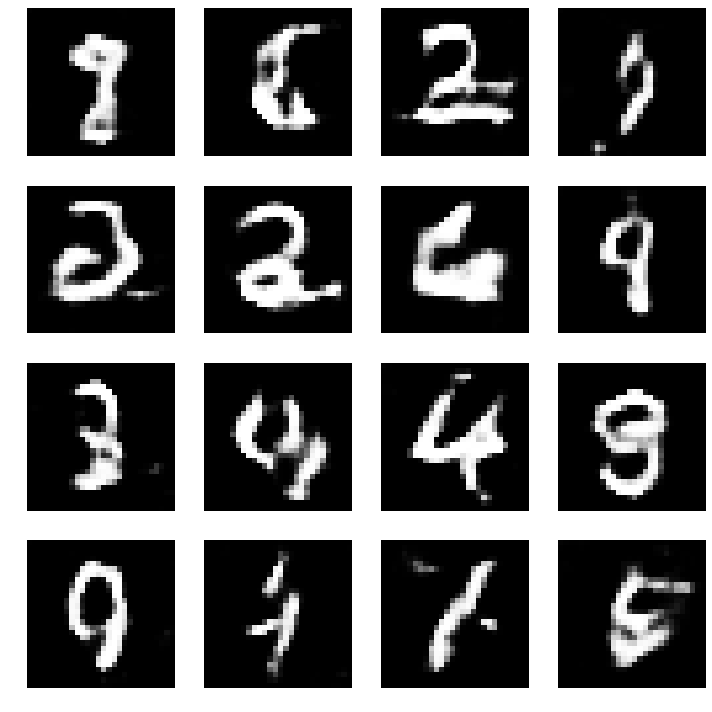

17499: [D loss: 0.437027, acc: 0.824219]  [A loss: 2.135859, acc: 0.093750]


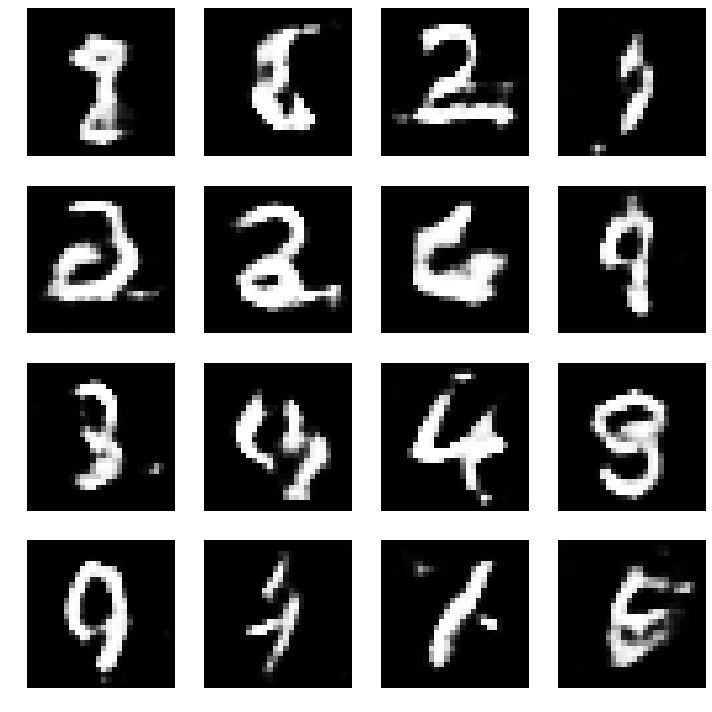

17999: [D loss: 0.466381, acc: 0.820312]  [A loss: 2.230271, acc: 0.062500]


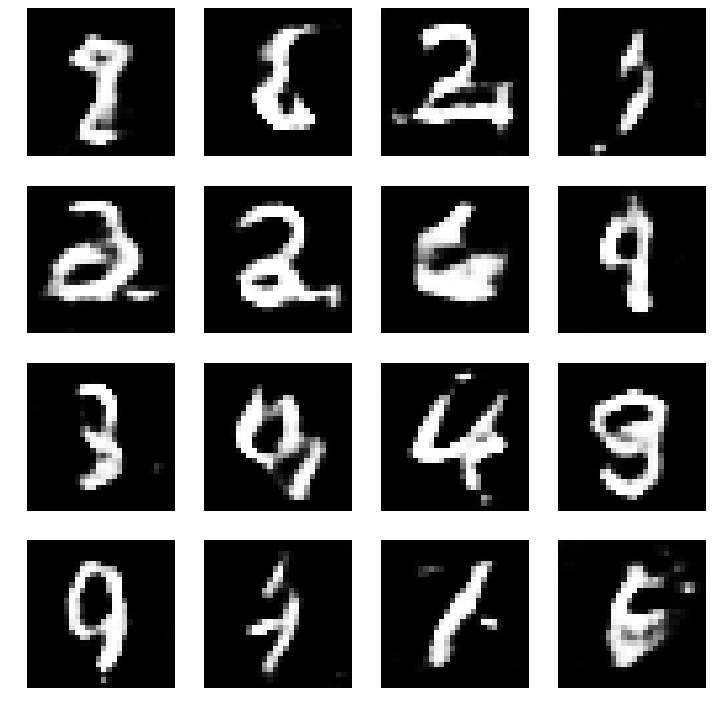

18499: [D loss: 0.457167, acc: 0.796875]  [A loss: 2.007551, acc: 0.140625]


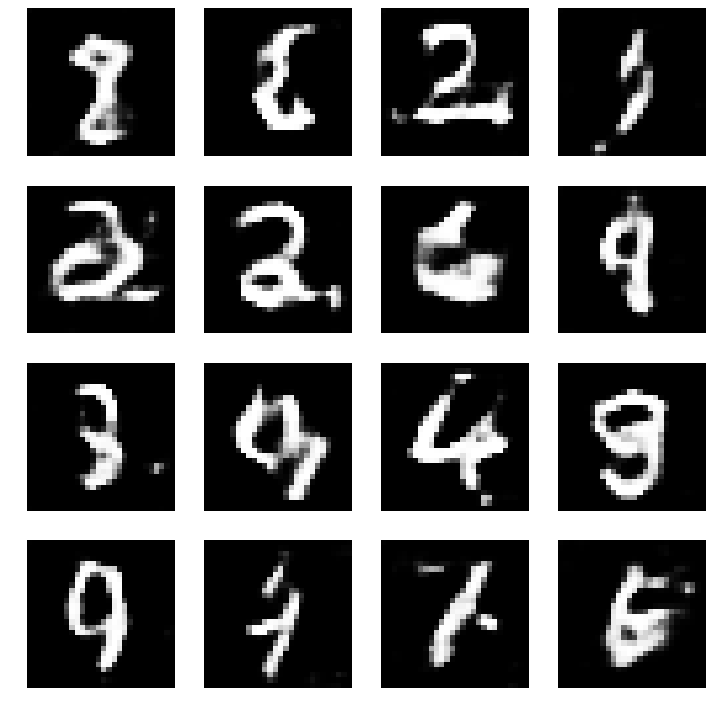

18999: [D loss: 0.398115, acc: 0.796875]  [A loss: 2.027929, acc: 0.156250]


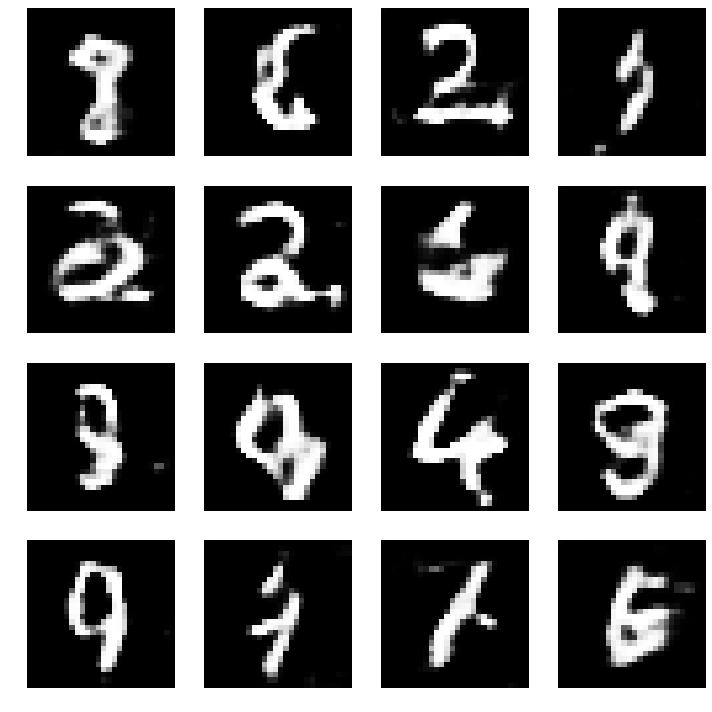

19499: [D loss: 0.490203, acc: 0.757812]  [A loss: 1.751266, acc: 0.195312]


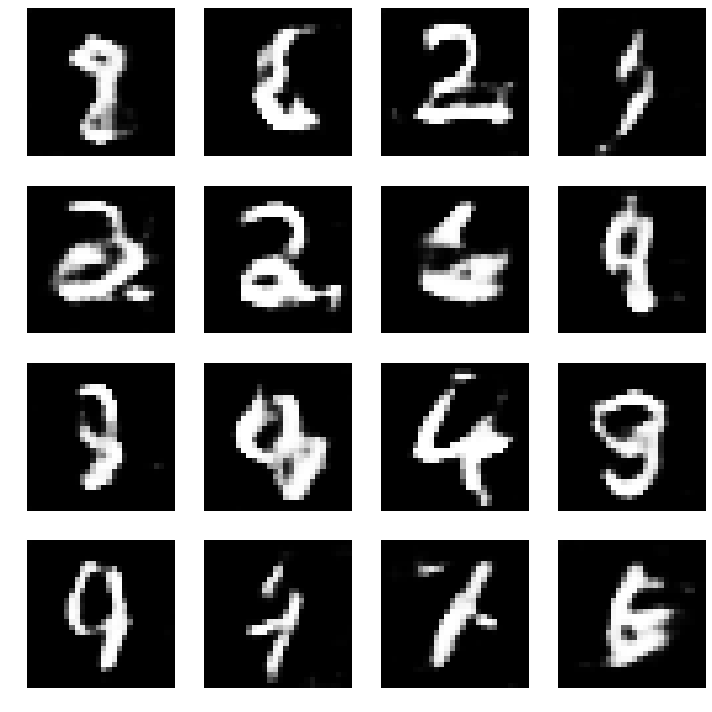

19999: [D loss: 0.453354, acc: 0.777344]  [A loss: 1.864340, acc: 0.156250]


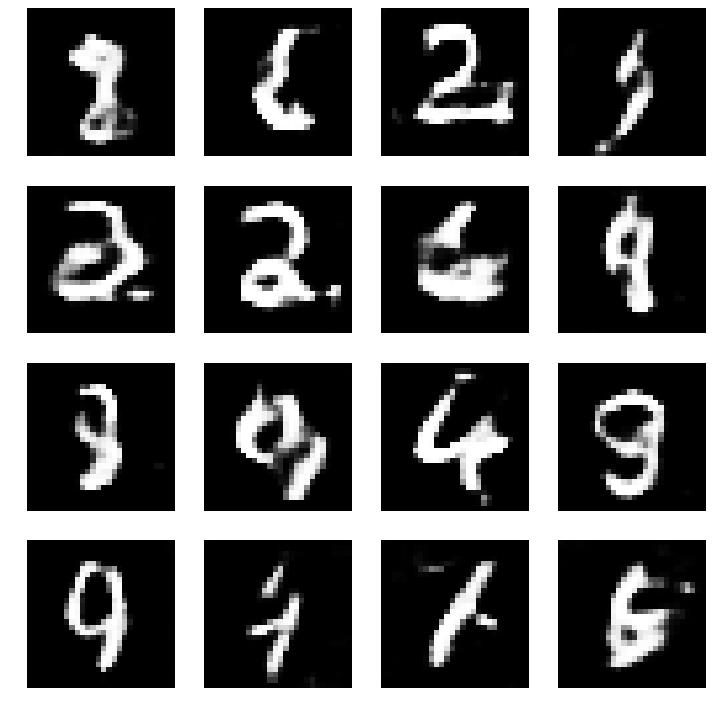

20499: [D loss: 0.377495, acc: 0.832031]  [A loss: 1.912484, acc: 0.140625]


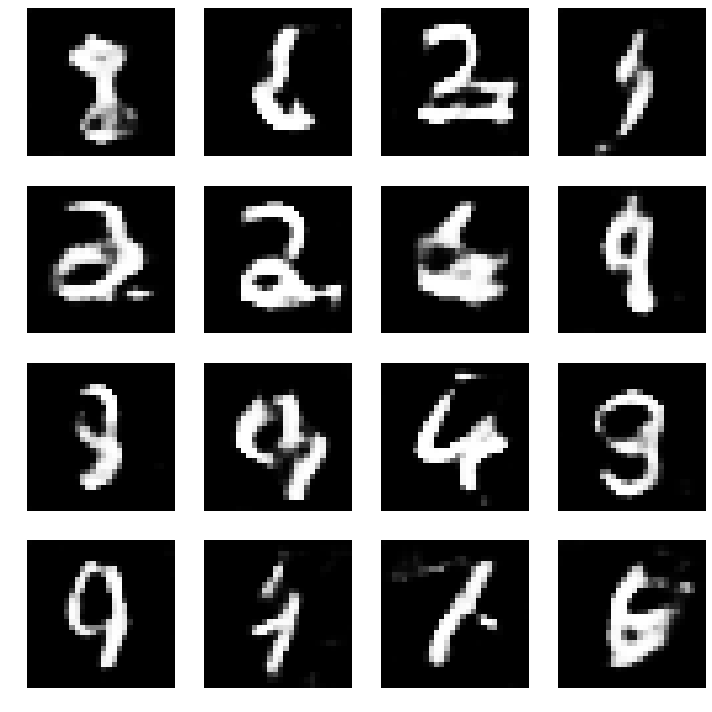

20999: [D loss: 0.450169, acc: 0.789062]  [A loss: 1.787030, acc: 0.171875]


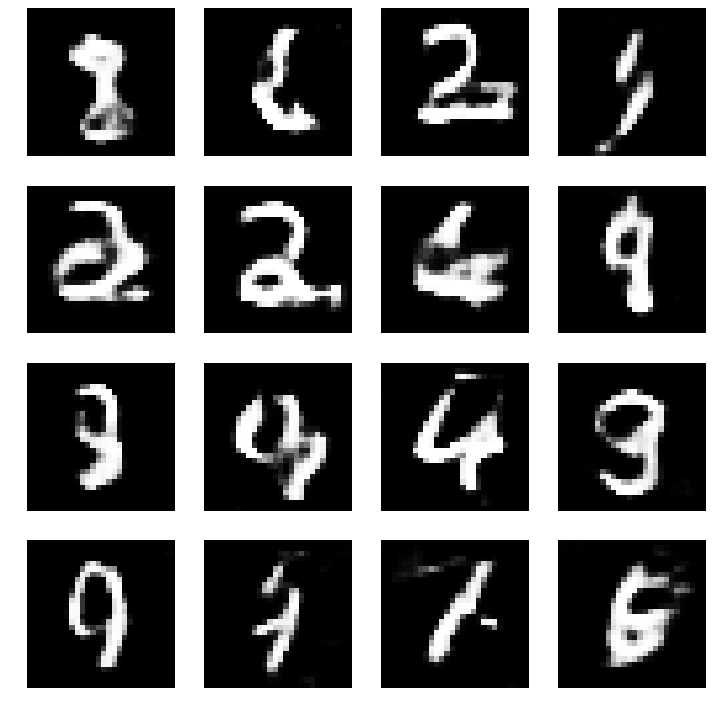

21499: [D loss: 0.386241, acc: 0.800781]  [A loss: 2.024732, acc: 0.164062]


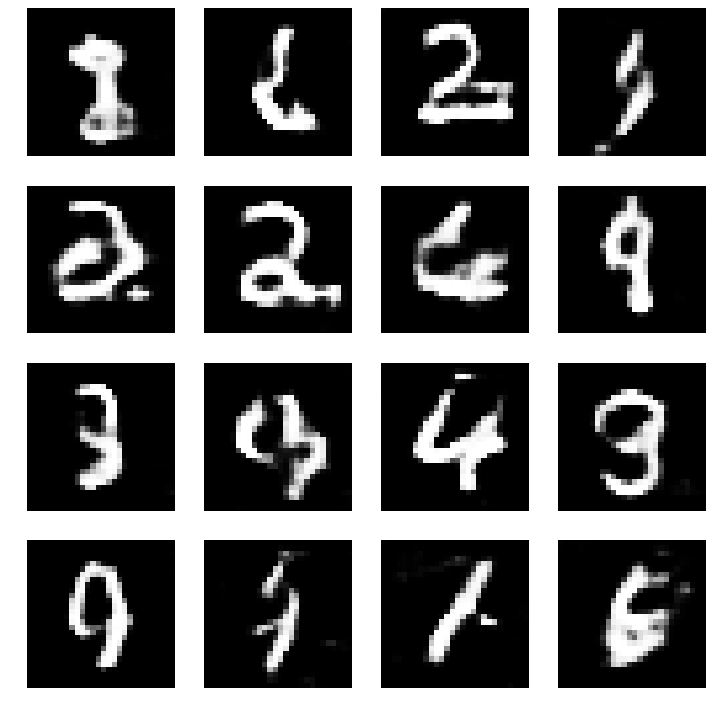

21999: [D loss: 0.451382, acc: 0.808594]  [A loss: 1.832923, acc: 0.148438]


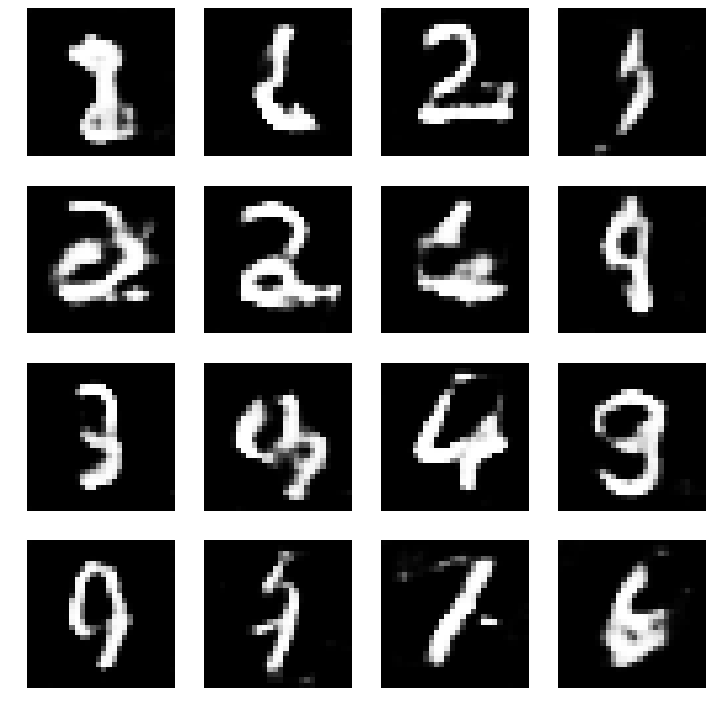

22499: [D loss: 0.474608, acc: 0.789062]  [A loss: 2.092419, acc: 0.132812]


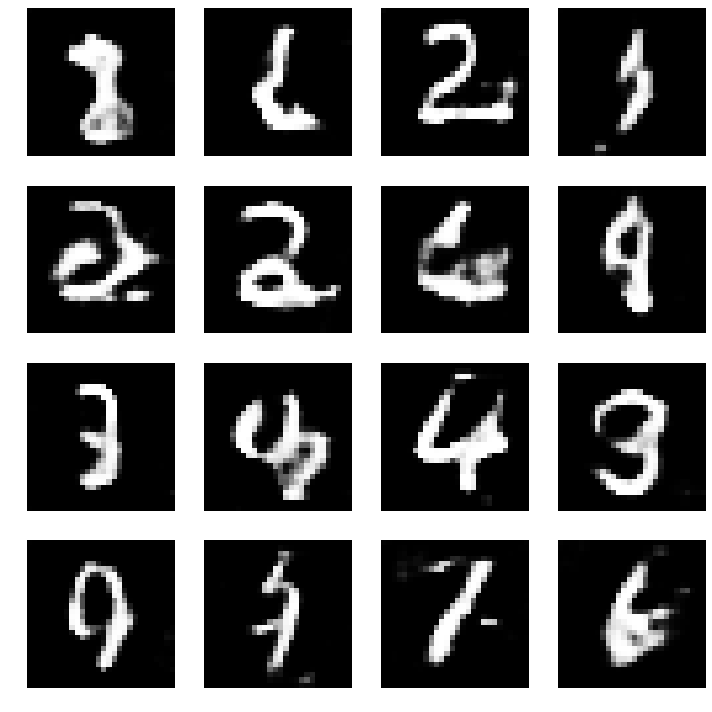

22999: [D loss: 0.451487, acc: 0.769531]  [A loss: 2.149282, acc: 0.101562]


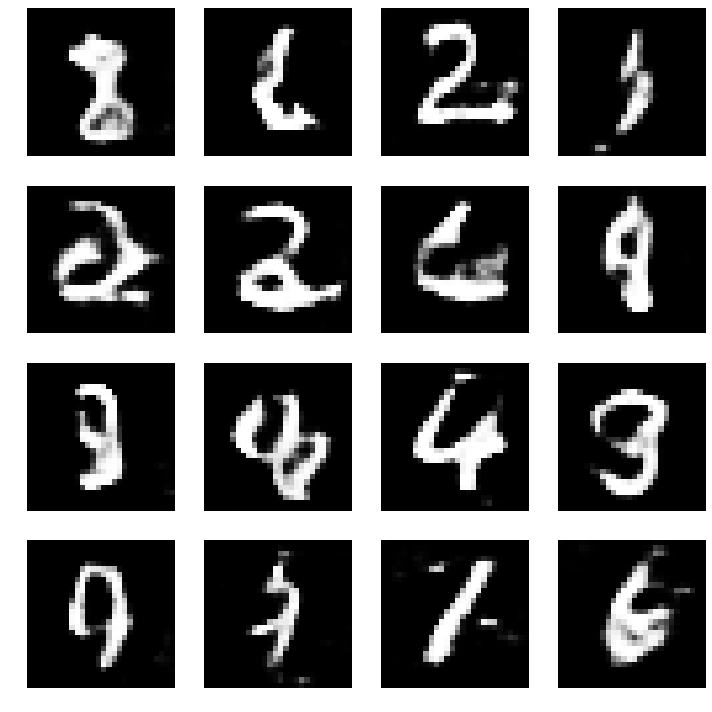

23499: [D loss: 0.450055, acc: 0.800781]  [A loss: 2.118799, acc: 0.085938]


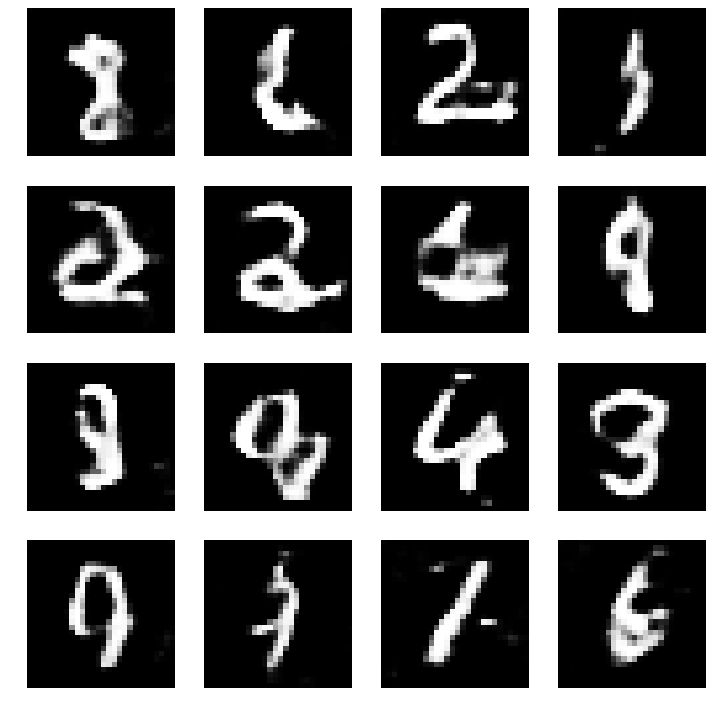

23999: [D loss: 0.398426, acc: 0.828125]  [A loss: 1.862728, acc: 0.140625]


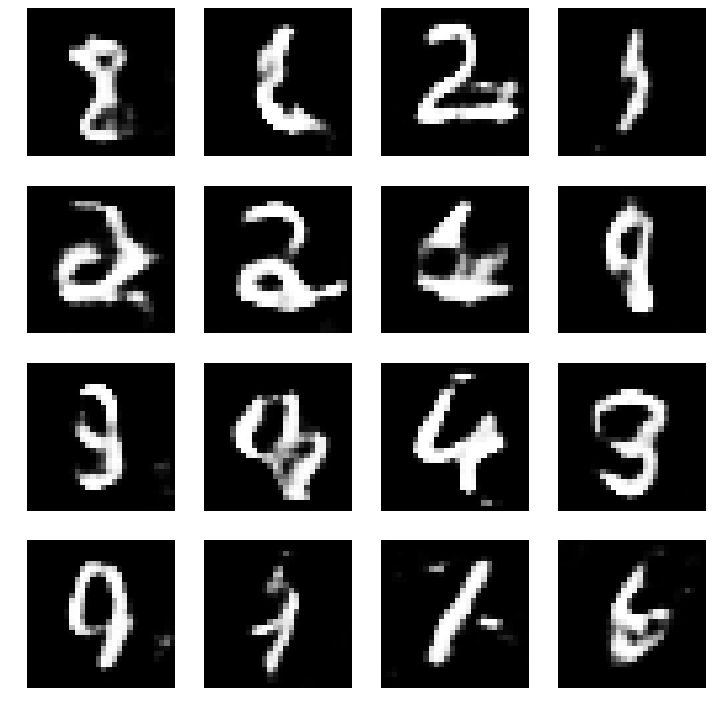

24499: [D loss: 0.508983, acc: 0.757812]  [A loss: 1.926036, acc: 0.148438]


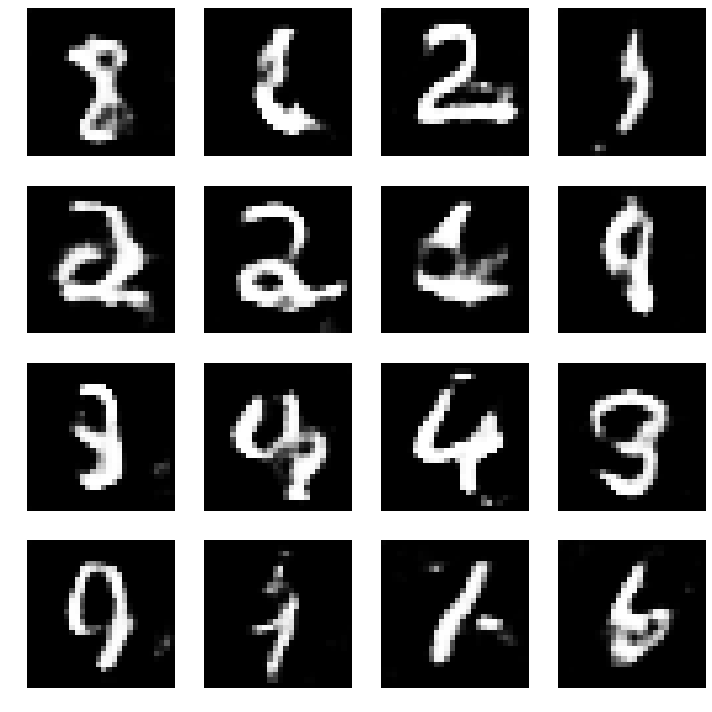

24999: [D loss: 0.446164, acc: 0.796875]  [A loss: 1.704033, acc: 0.148438]


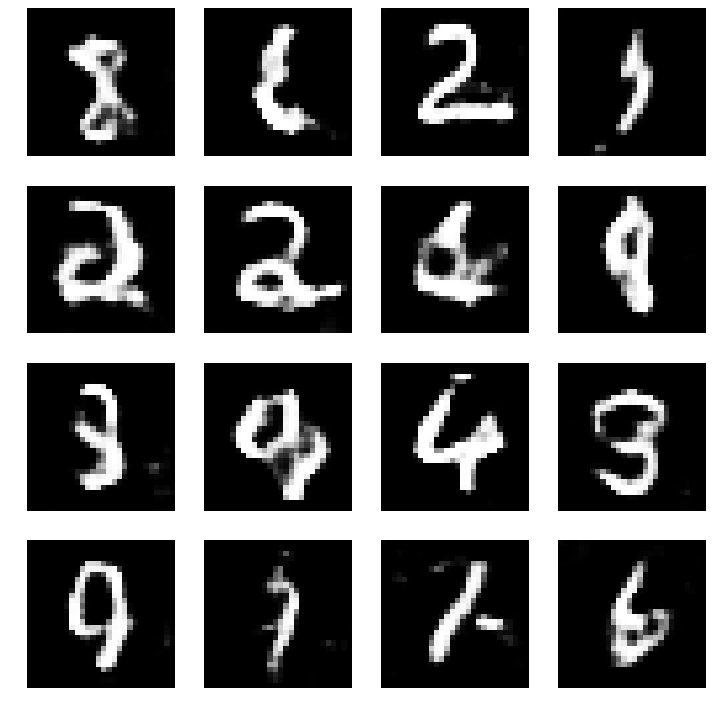

25499: [D loss: 0.449159, acc: 0.781250]  [A loss: 1.833068, acc: 0.125000]


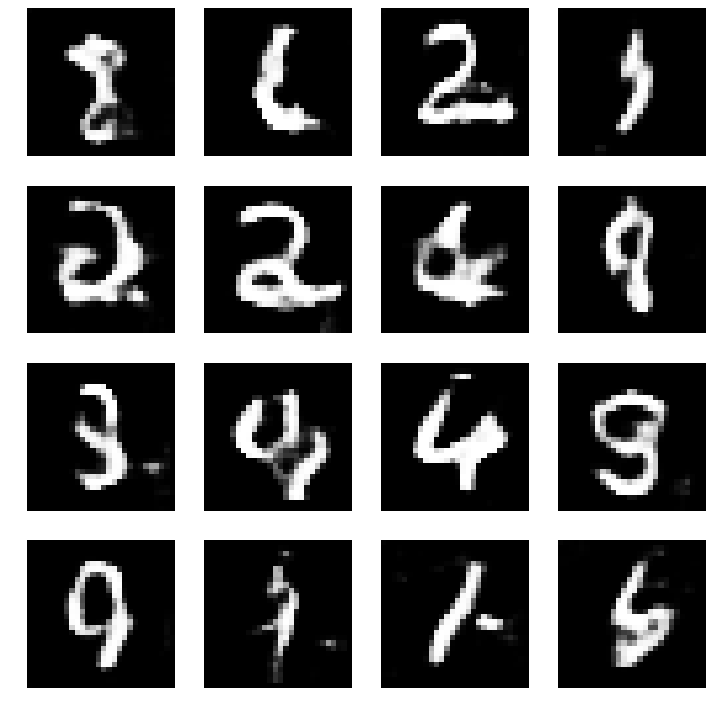

25999: [D loss: 0.440456, acc: 0.781250]  [A loss: 1.832166, acc: 0.148438]


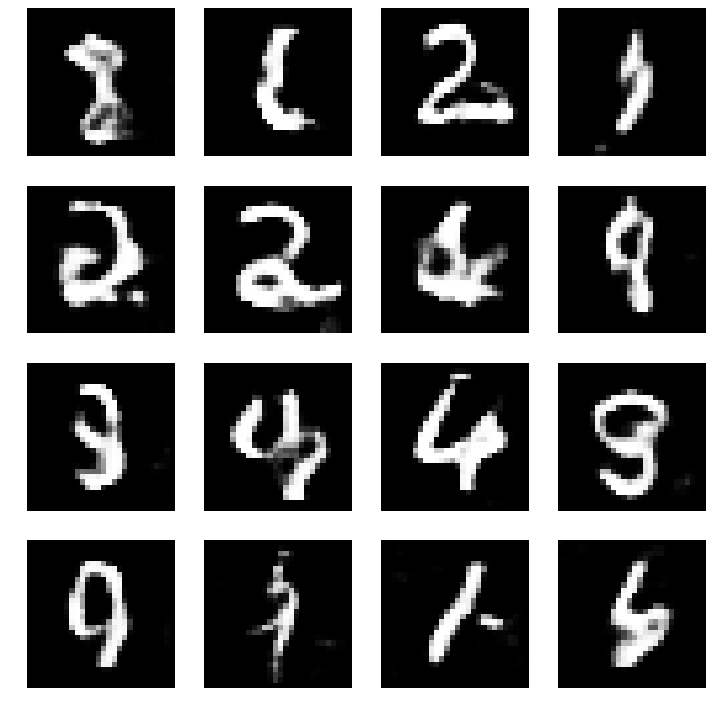

26499: [D loss: 0.435943, acc: 0.800781]  [A loss: 1.808572, acc: 0.156250]


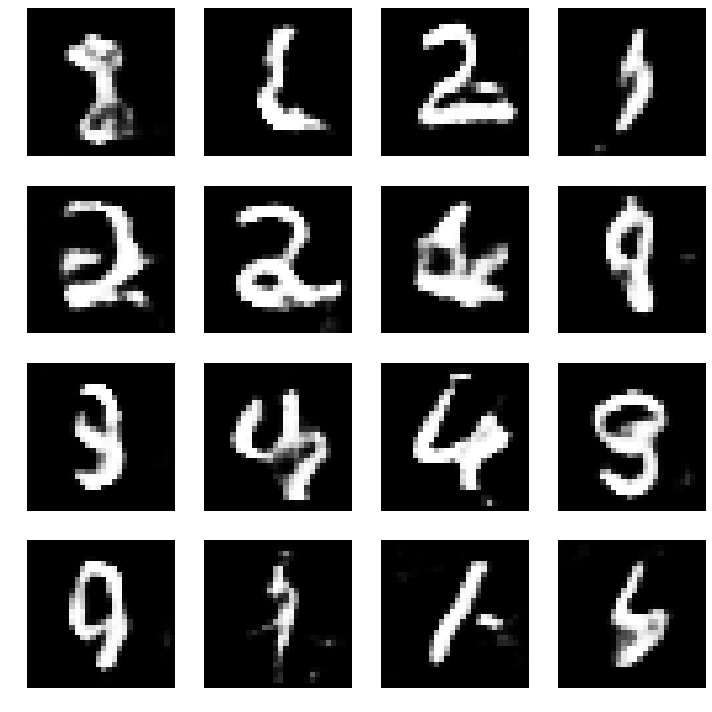

26999: [D loss: 0.463668, acc: 0.808594]  [A loss: 1.809359, acc: 0.187500]


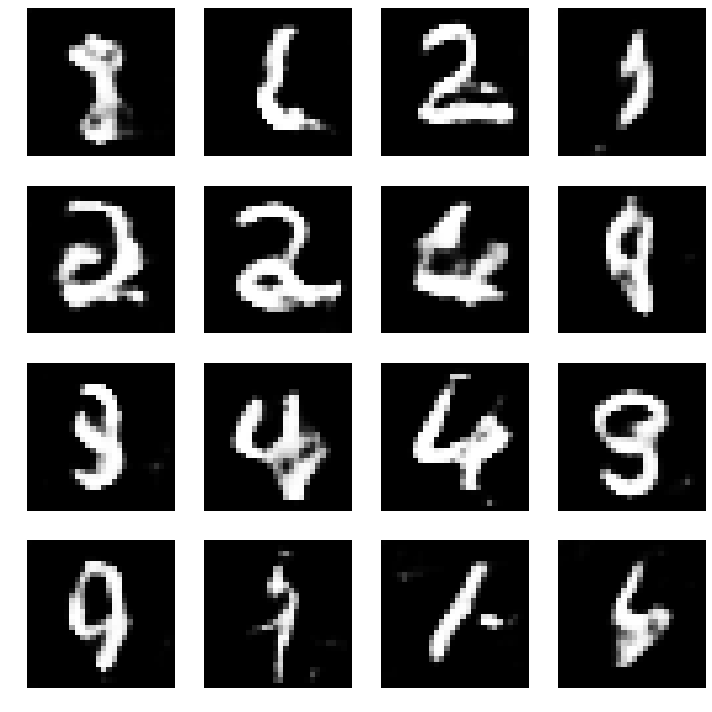

27499: [D loss: 0.386319, acc: 0.828125]  [A loss: 1.727144, acc: 0.085938]


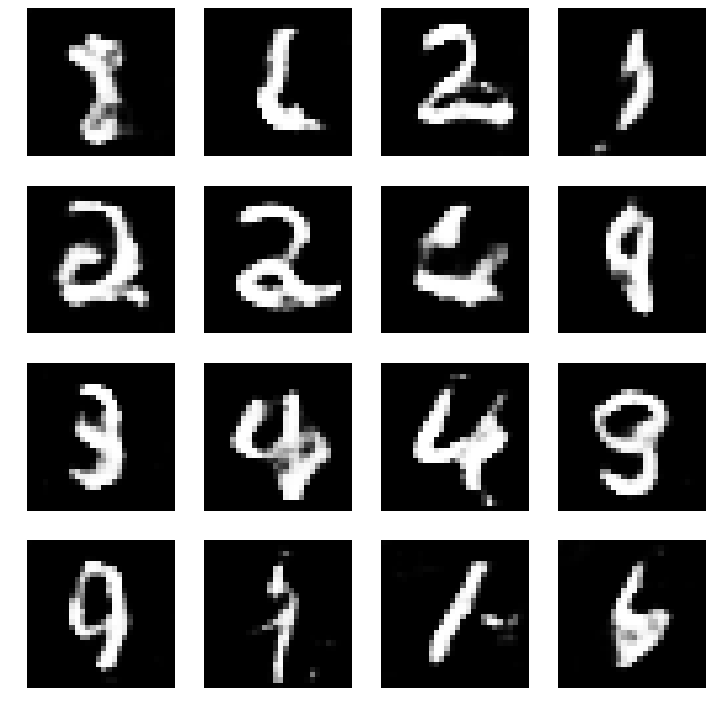

27999: [D loss: 0.506478, acc: 0.734375]  [A loss: 1.769843, acc: 0.156250]


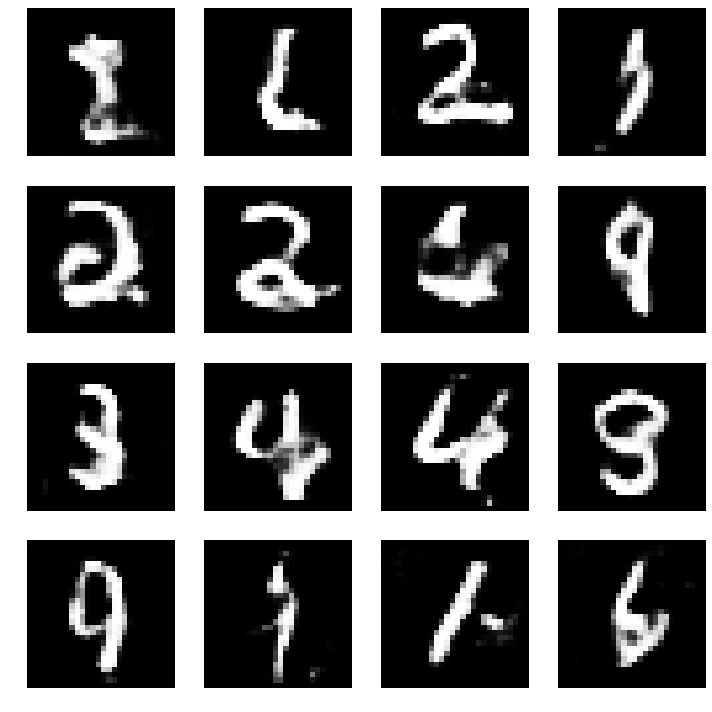

28499: [D loss: 0.482652, acc: 0.765625]  [A loss: 1.708069, acc: 0.218750]


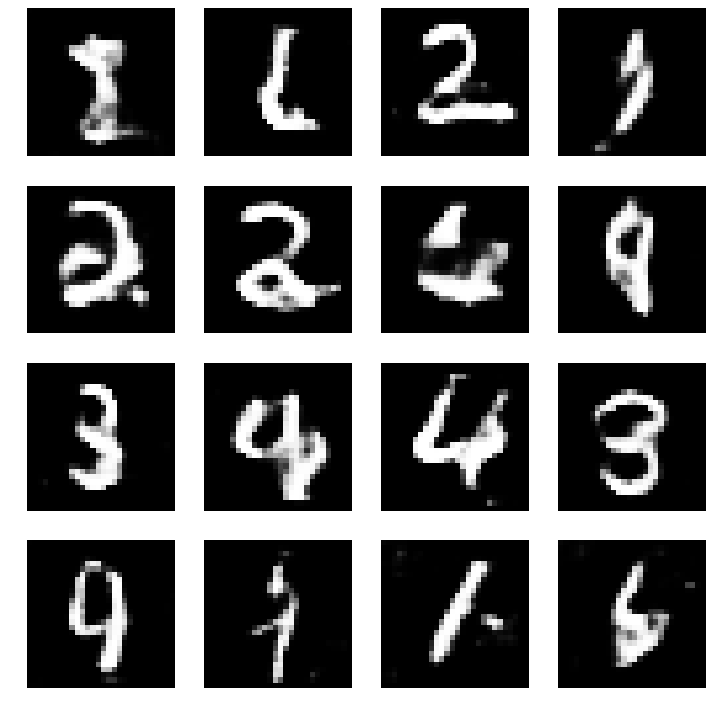

28999: [D loss: 0.476820, acc: 0.785156]  [A loss: 1.802239, acc: 0.171875]


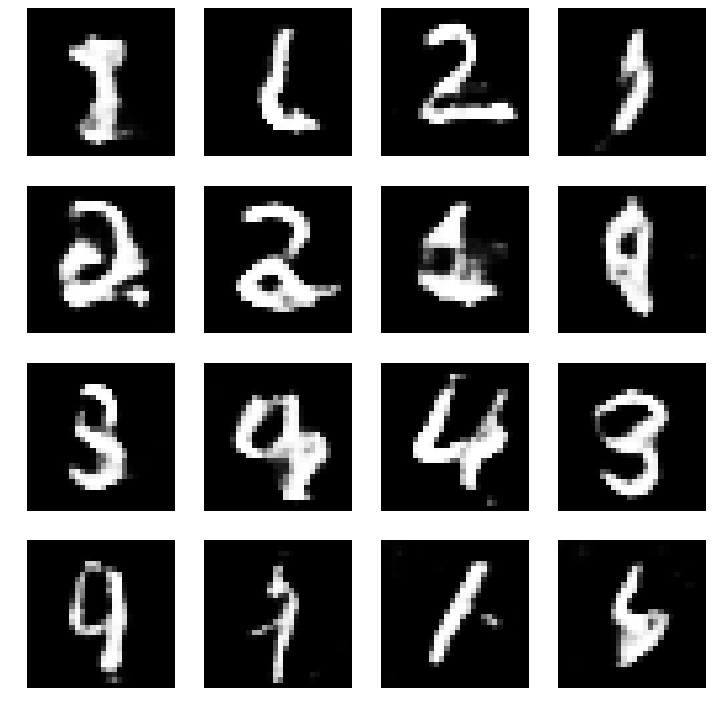

29499: [D loss: 0.532271, acc: 0.734375]  [A loss: 1.862515, acc: 0.132812]


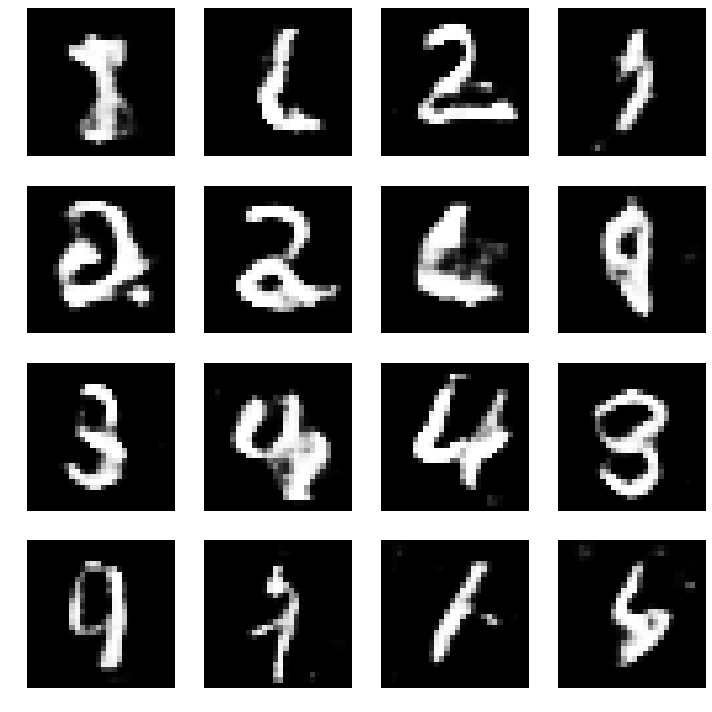

29999: [D loss: 0.420163, acc: 0.796875]  [A loss: 1.694920, acc: 0.164062]


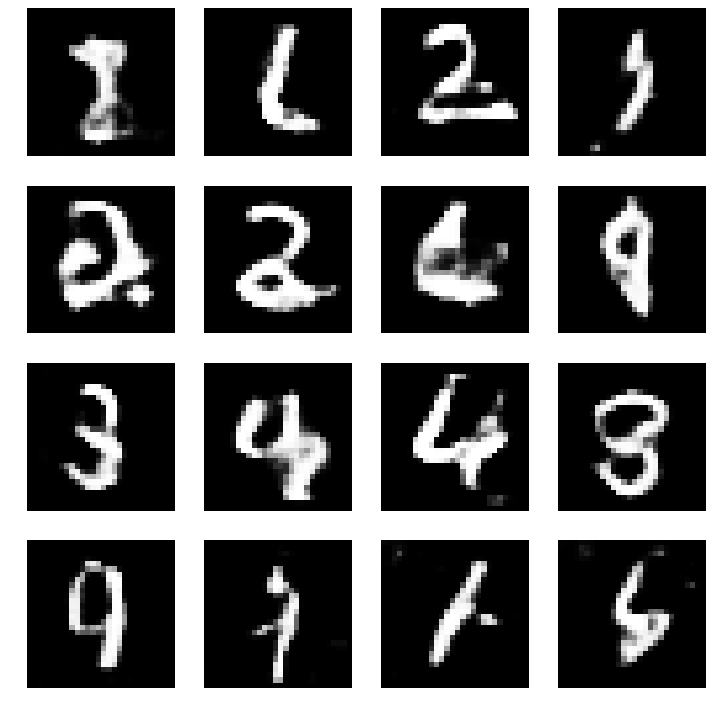

30499: [D loss: 0.511694, acc: 0.742188]  [A loss: 1.711693, acc: 0.109375]


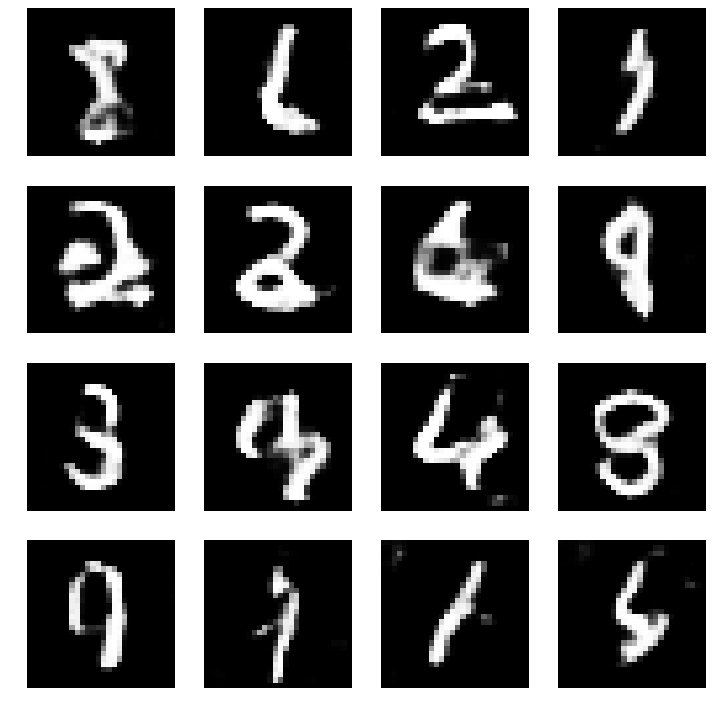

30999: [D loss: 0.460247, acc: 0.804688]  [A loss: 1.667340, acc: 0.203125]


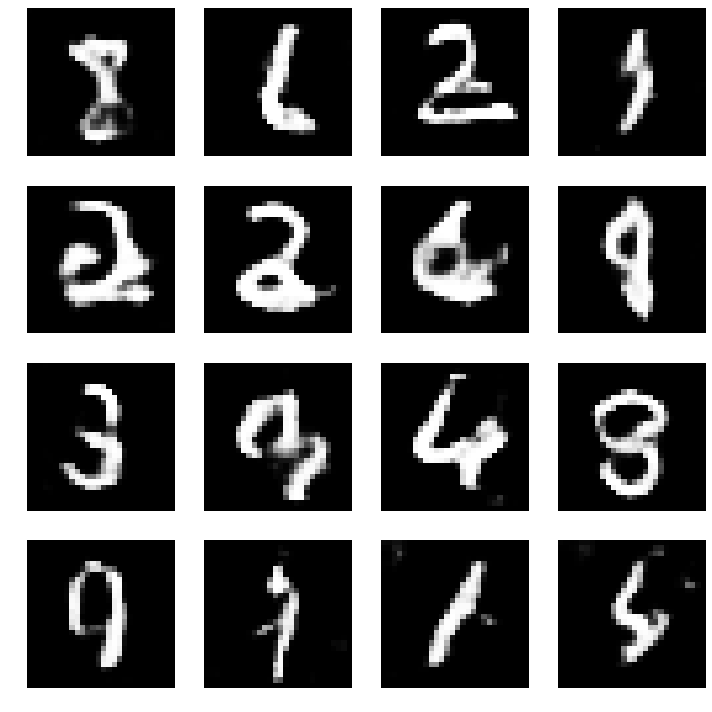

31499: [D loss: 0.492380, acc: 0.761719]  [A loss: 1.996203, acc: 0.093750]


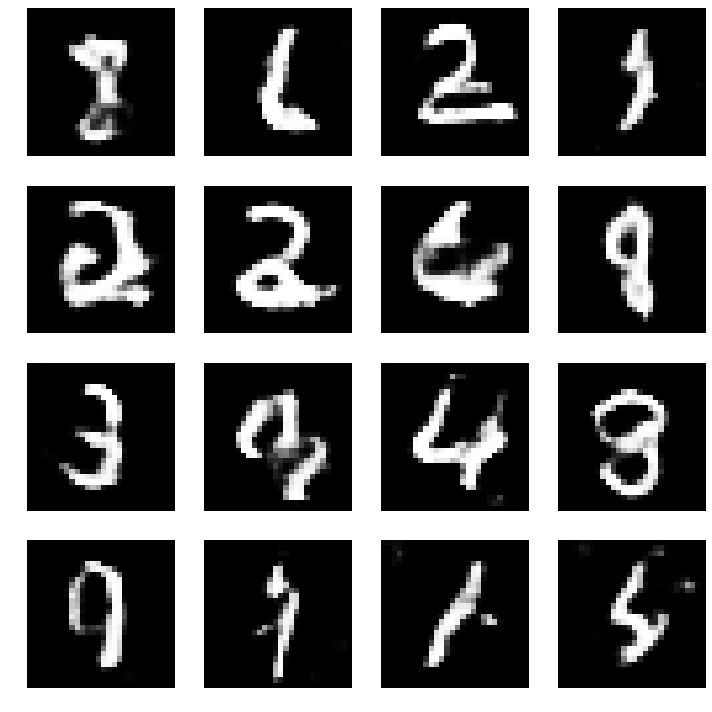

31999: [D loss: 0.458761, acc: 0.808594]  [A loss: 1.629528, acc: 0.171875]


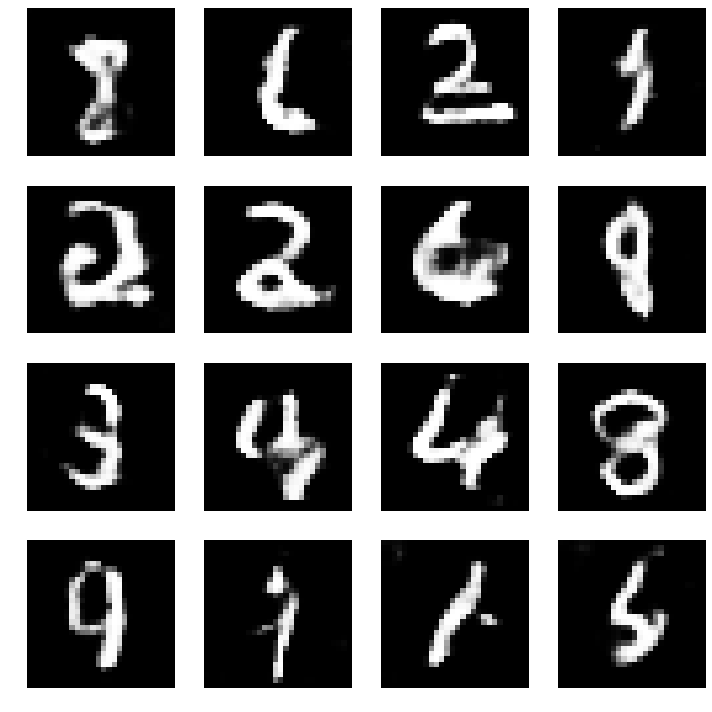

32499: [D loss: 0.577996, acc: 0.738281]  [A loss: 1.691819, acc: 0.203125]


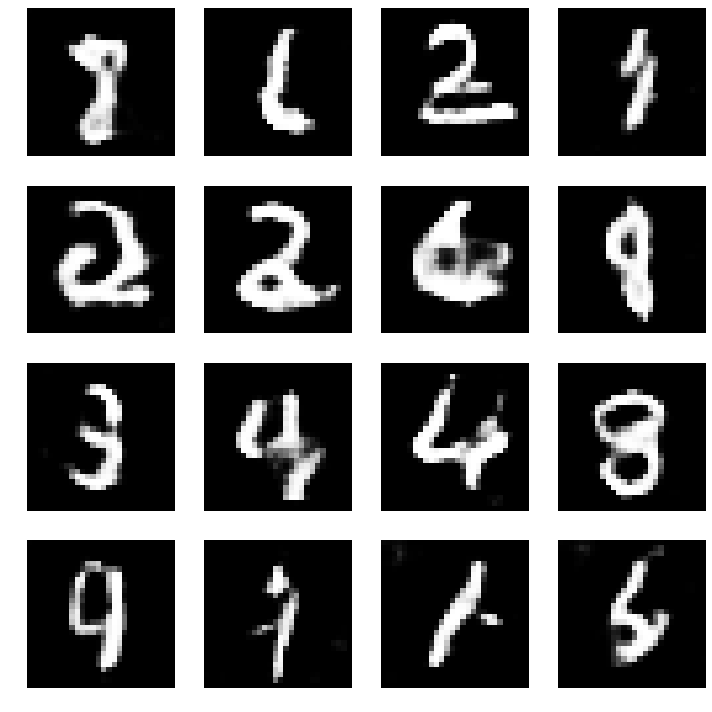

32999: [D loss: 0.504055, acc: 0.761719]  [A loss: 1.529352, acc: 0.156250]


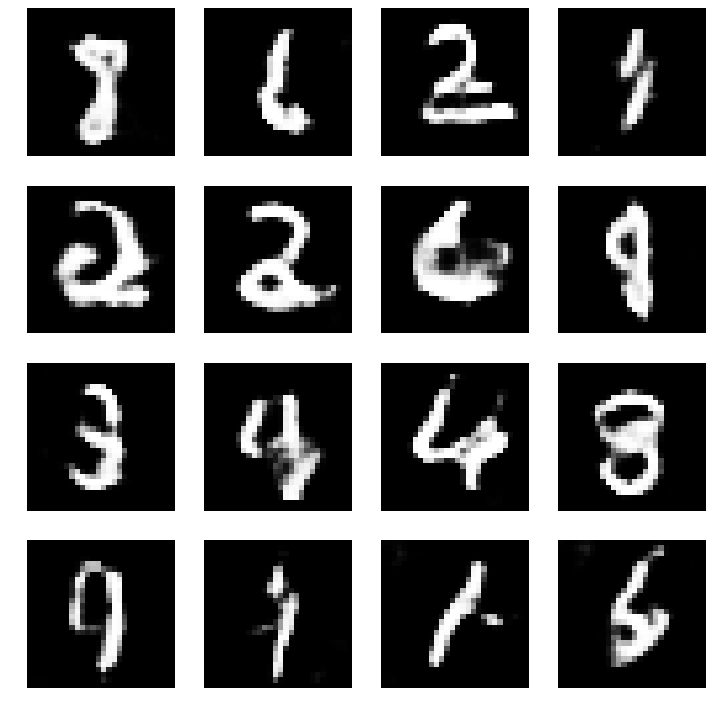

33499: [D loss: 0.624057, acc: 0.683594]  [A loss: 1.634564, acc: 0.218750]


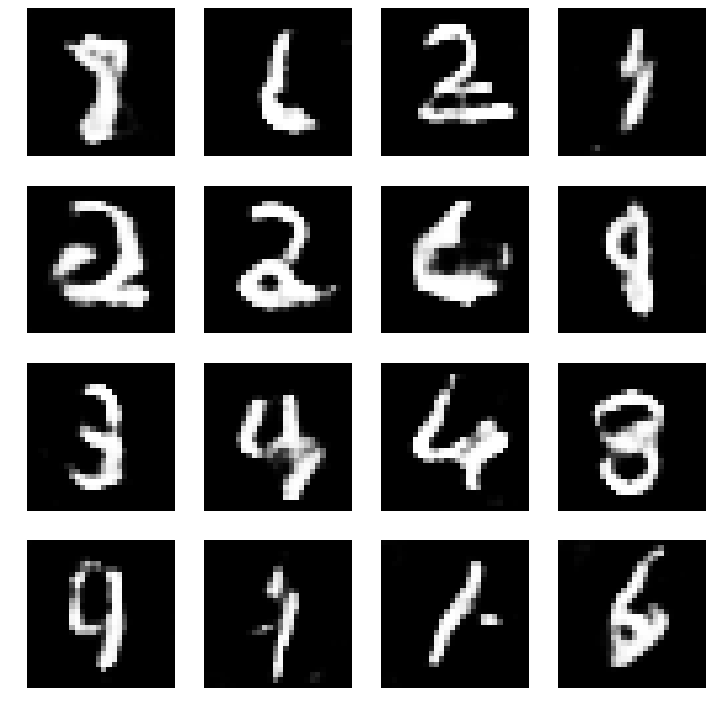

33999: [D loss: 0.541754, acc: 0.738281]  [A loss: 1.683074, acc: 0.156250]


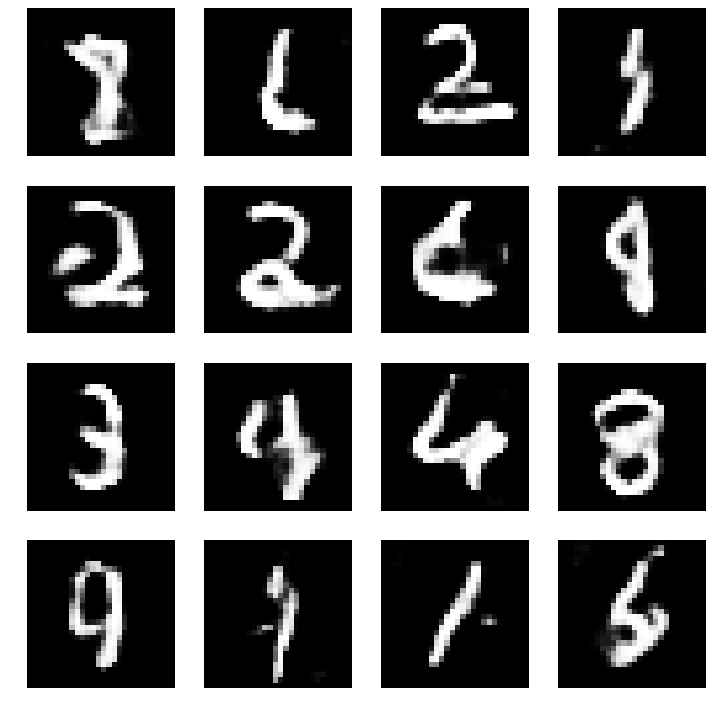

34499: [D loss: 0.433927, acc: 0.812500]  [A loss: 1.659179, acc: 0.203125]


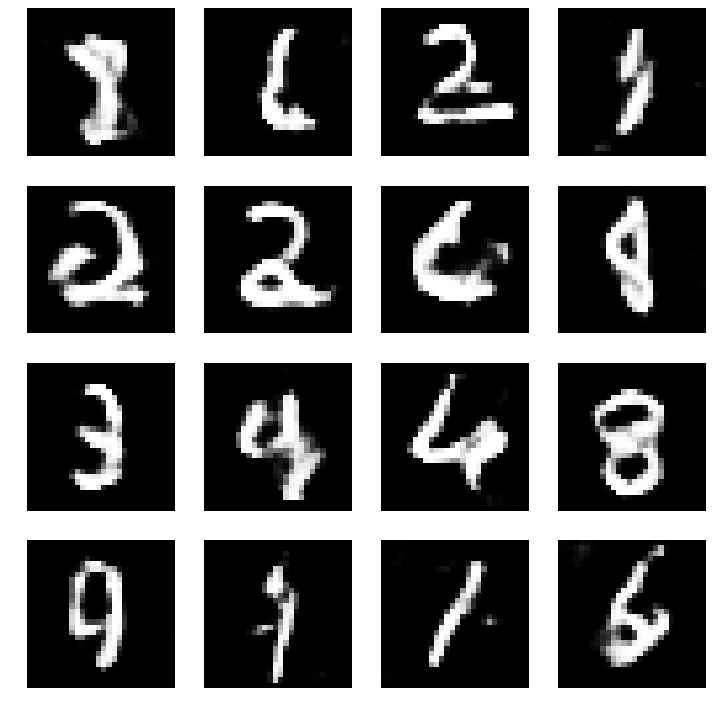

34999: [D loss: 0.471176, acc: 0.765625]  [A loss: 1.741927, acc: 0.125000]


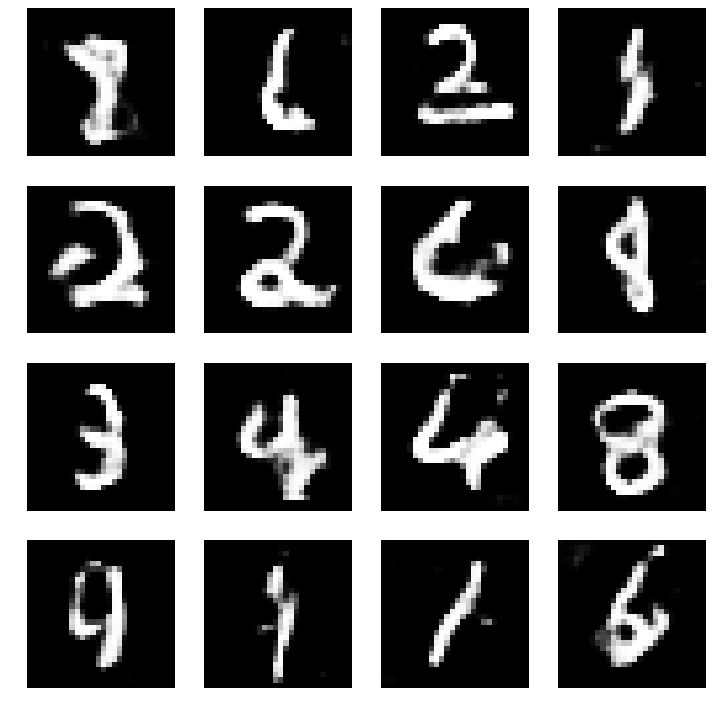

35499: [D loss: 0.524199, acc: 0.730469]  [A loss: 1.607947, acc: 0.125000]


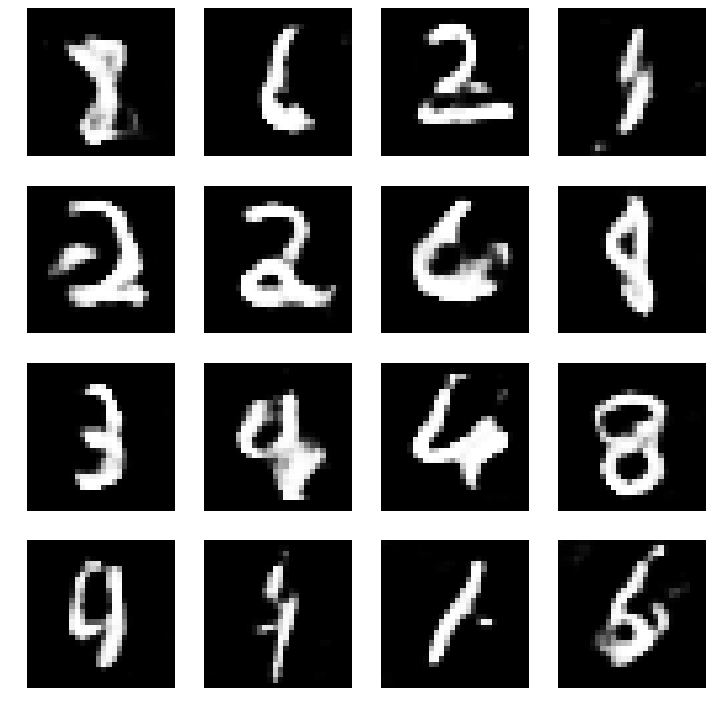

35999: [D loss: 0.431827, acc: 0.789062]  [A loss: 1.916019, acc: 0.132812]


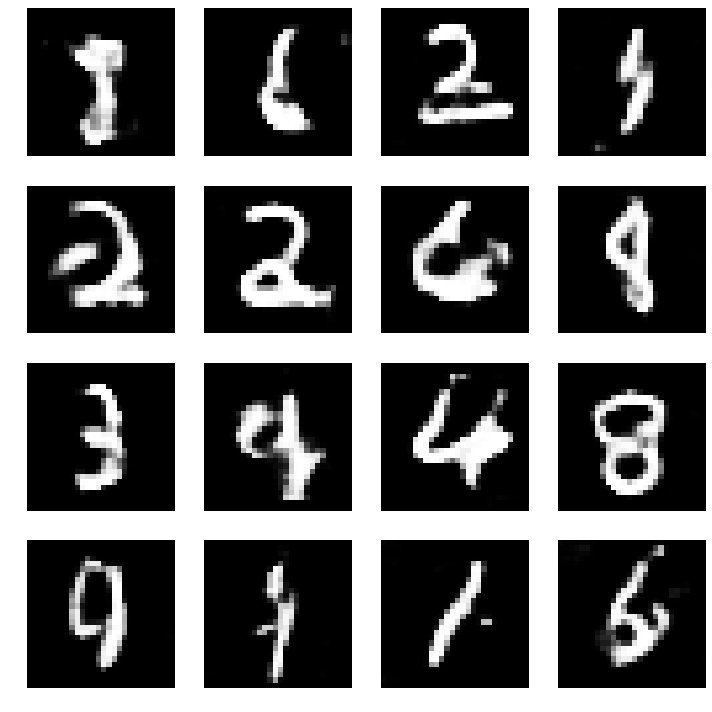

36499: [D loss: 0.512212, acc: 0.730469]  [A loss: 1.684001, acc: 0.171875]


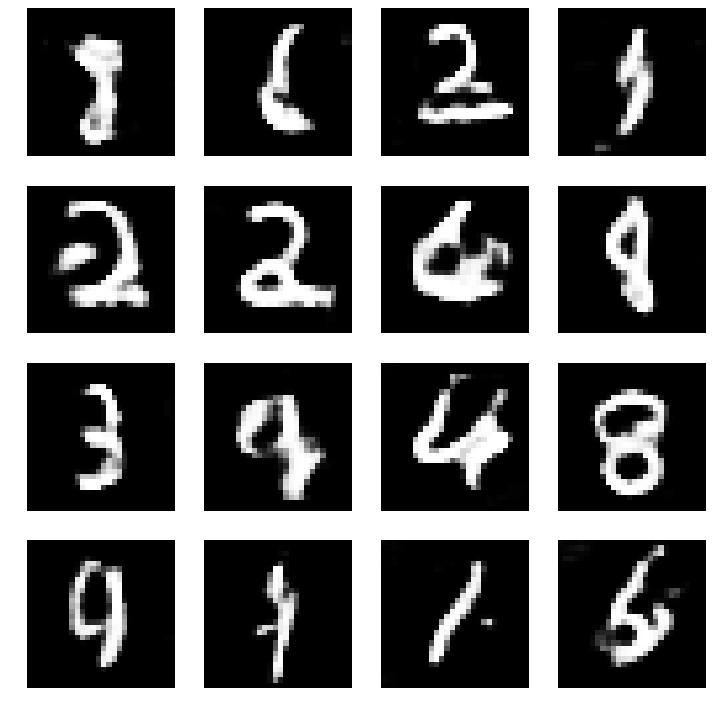

36999: [D loss: 0.523308, acc: 0.738281]  [A loss: 1.601604, acc: 0.250000]


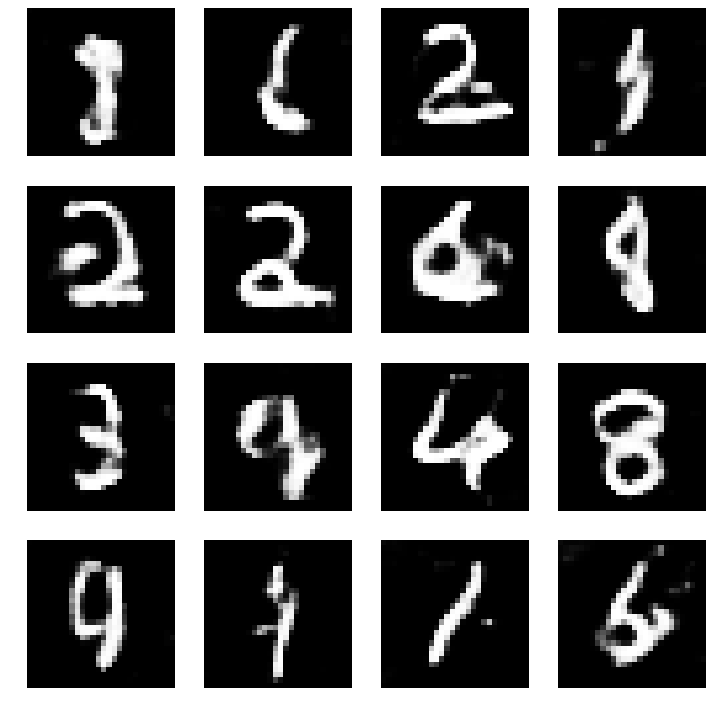

37499: [D loss: 0.576954, acc: 0.714844]  [A loss: 1.550792, acc: 0.195312]


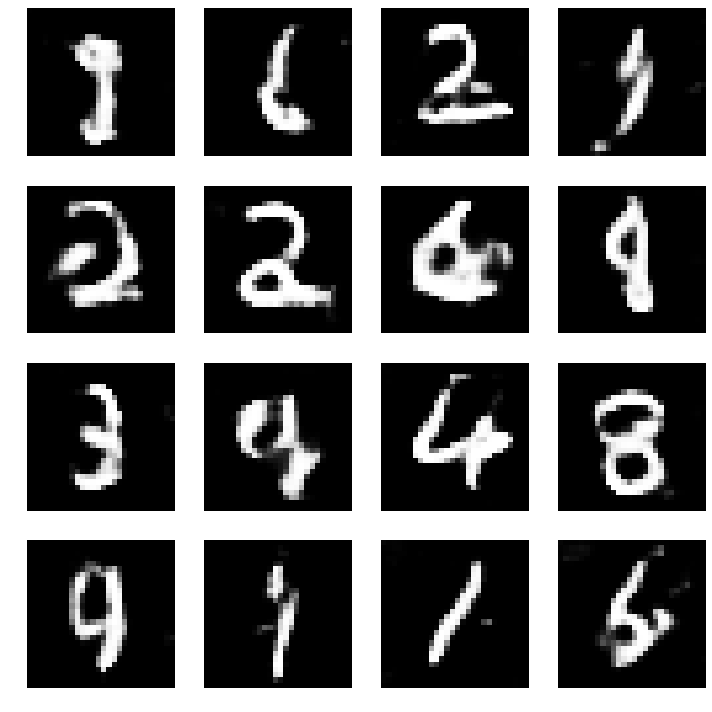

37999: [D loss: 0.487850, acc: 0.781250]  [A loss: 1.669400, acc: 0.148438]


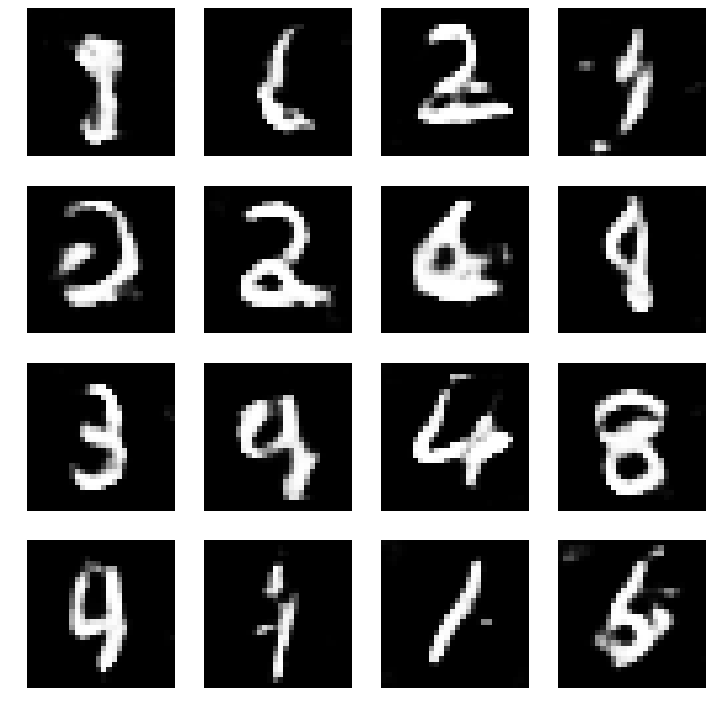

38499: [D loss: 0.467916, acc: 0.761719]  [A loss: 1.494517, acc: 0.210938]


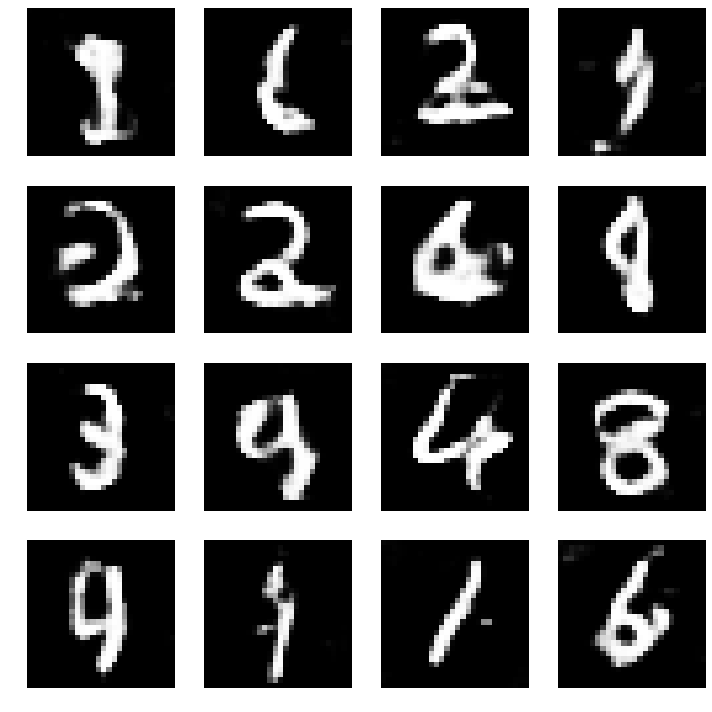

38999: [D loss: 0.523357, acc: 0.757812]  [A loss: 1.439052, acc: 0.257812]


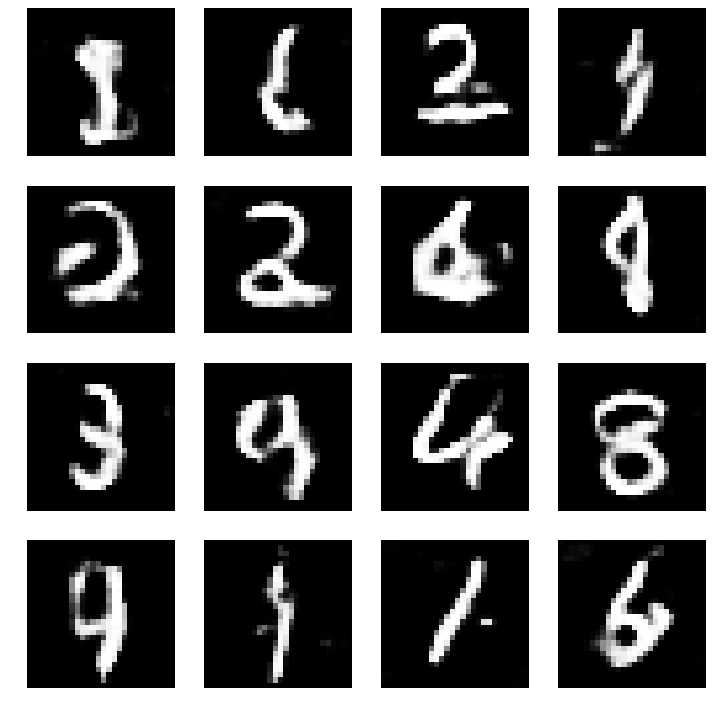

39499: [D loss: 0.486966, acc: 0.781250]  [A loss: 1.563093, acc: 0.195312]


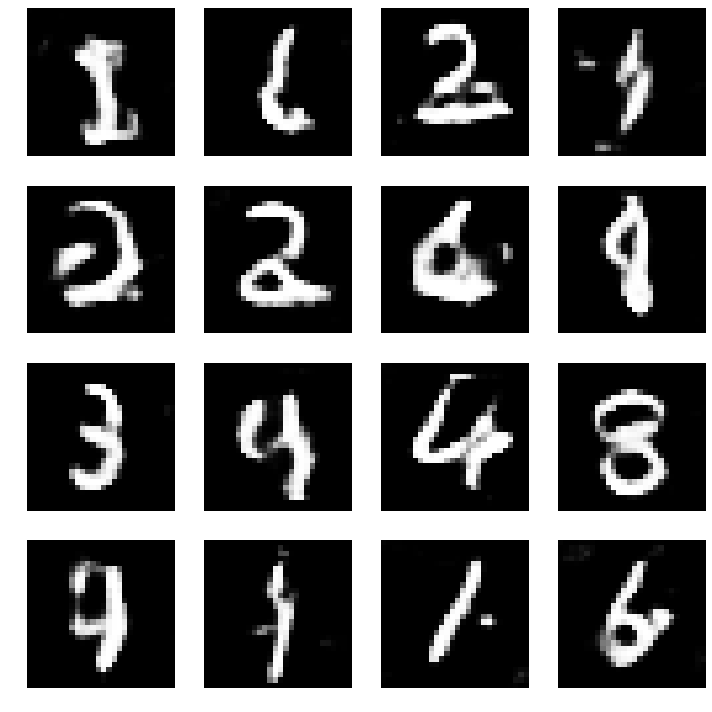

39999: [D loss: 0.499657, acc: 0.773438]  [A loss: 1.499592, acc: 0.164062]


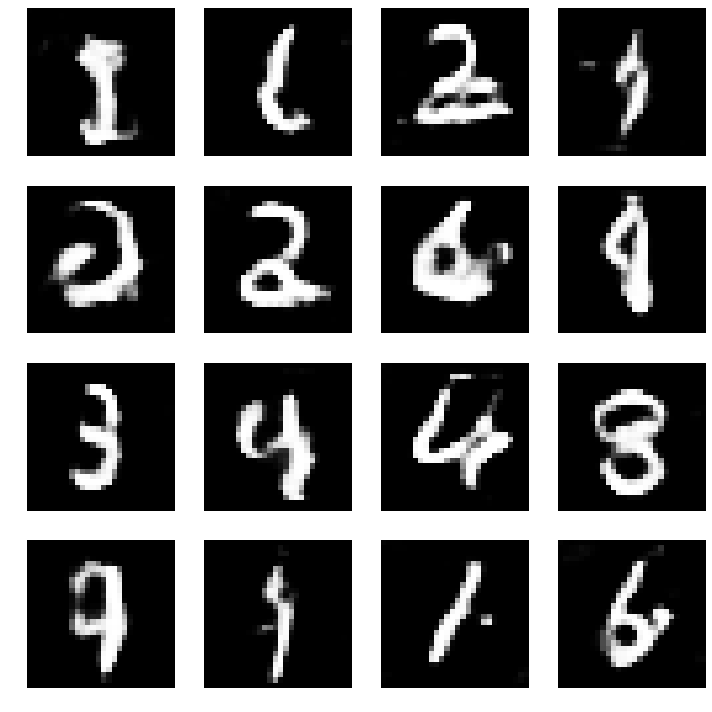

40499: [D loss: 0.570771, acc: 0.707031]  [A loss: 1.614330, acc: 0.179688]


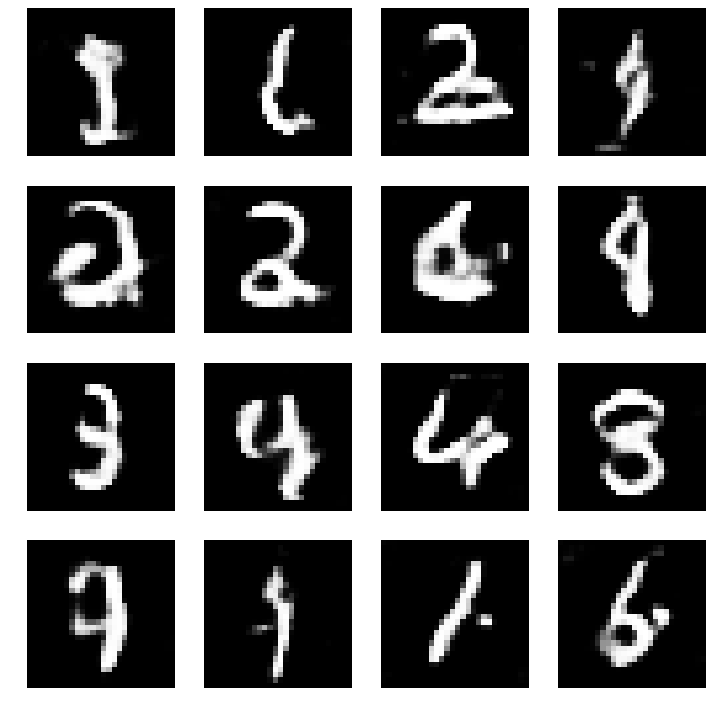

40999: [D loss: 0.489279, acc: 0.765625]  [A loss: 1.544361, acc: 0.218750]


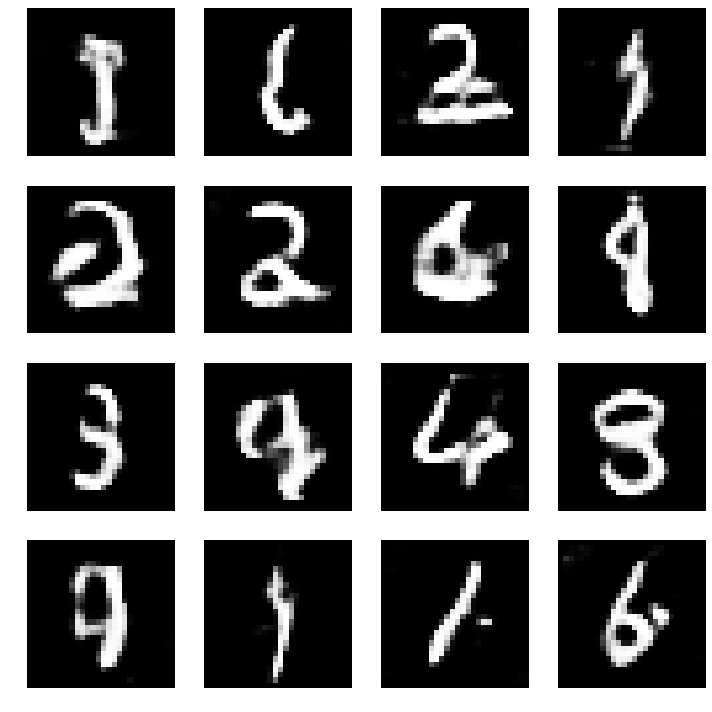

41499: [D loss: 0.495779, acc: 0.769531]  [A loss: 1.568240, acc: 0.234375]


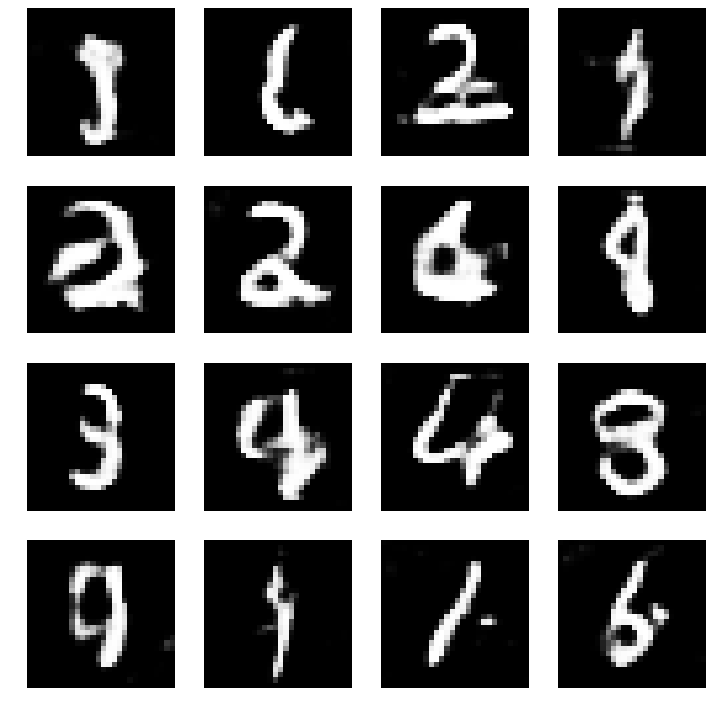

41999: [D loss: 0.548527, acc: 0.707031]  [A loss: 1.659606, acc: 0.203125]


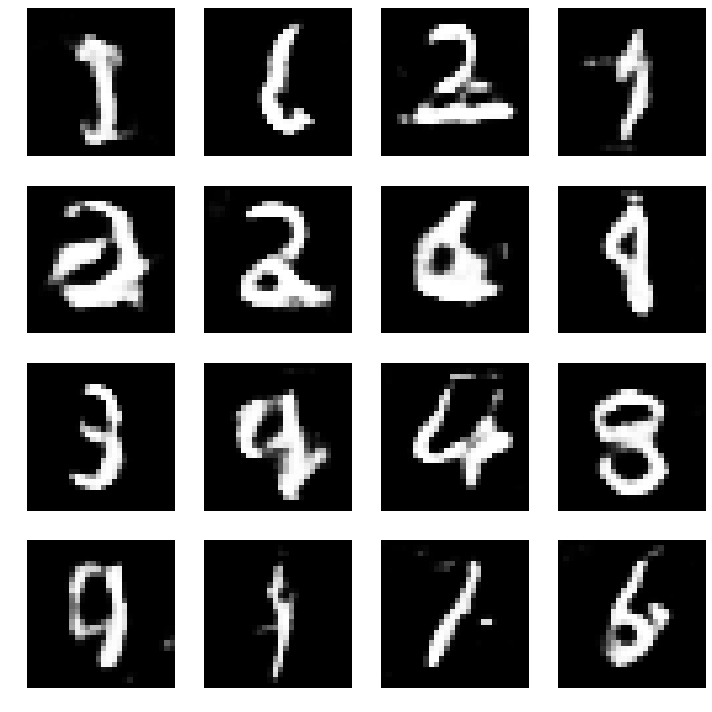

42499: [D loss: 0.497860, acc: 0.773438]  [A loss: 1.619500, acc: 0.195312]


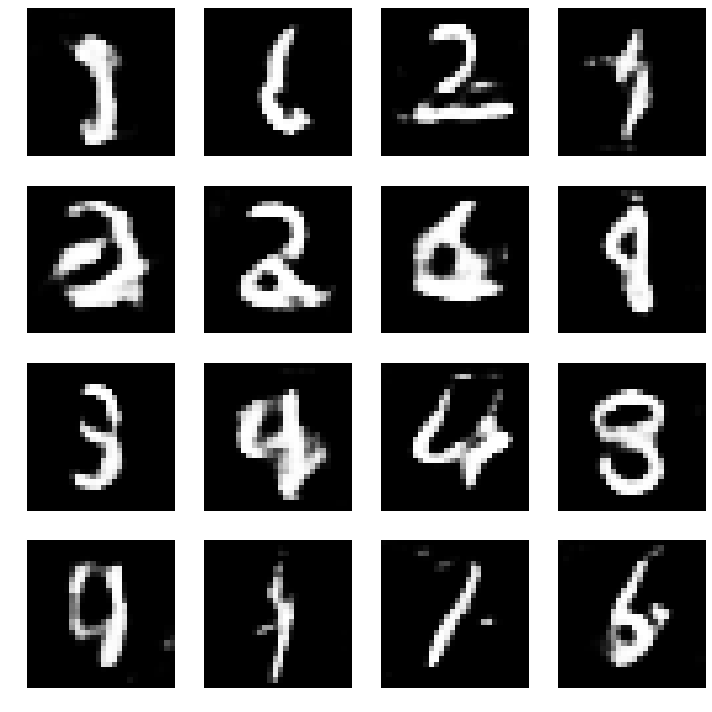

42999: [D loss: 0.581726, acc: 0.703125]  [A loss: 1.612925, acc: 0.171875]


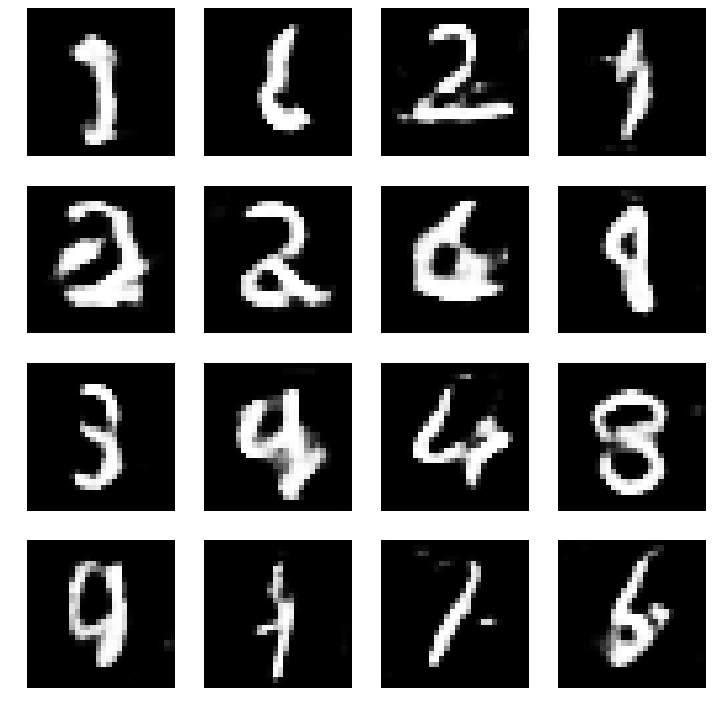

43499: [D loss: 0.533553, acc: 0.769531]  [A loss: 1.407539, acc: 0.226562]


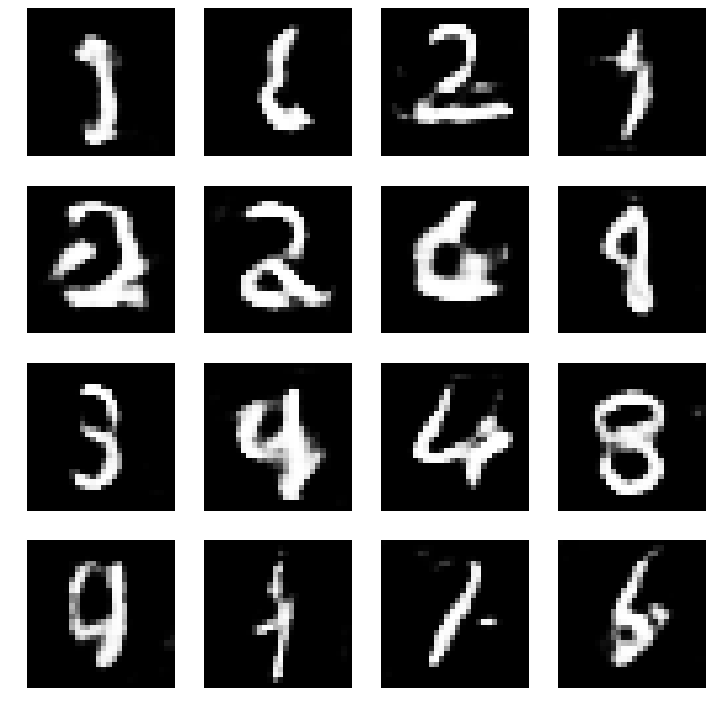

43999: [D loss: 0.536847, acc: 0.726562]  [A loss: 1.490733, acc: 0.218750]


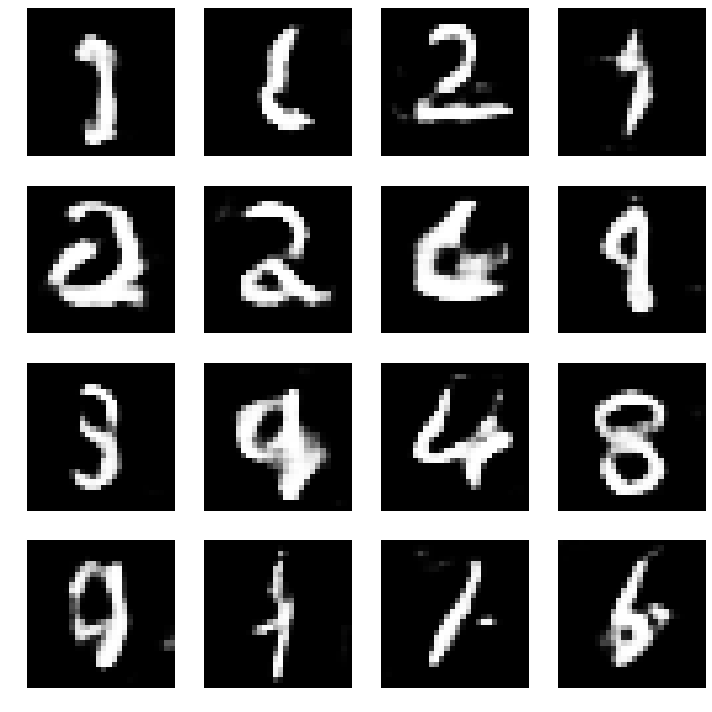

44499: [D loss: 0.561196, acc: 0.730469]  [A loss: 1.385485, acc: 0.250000]


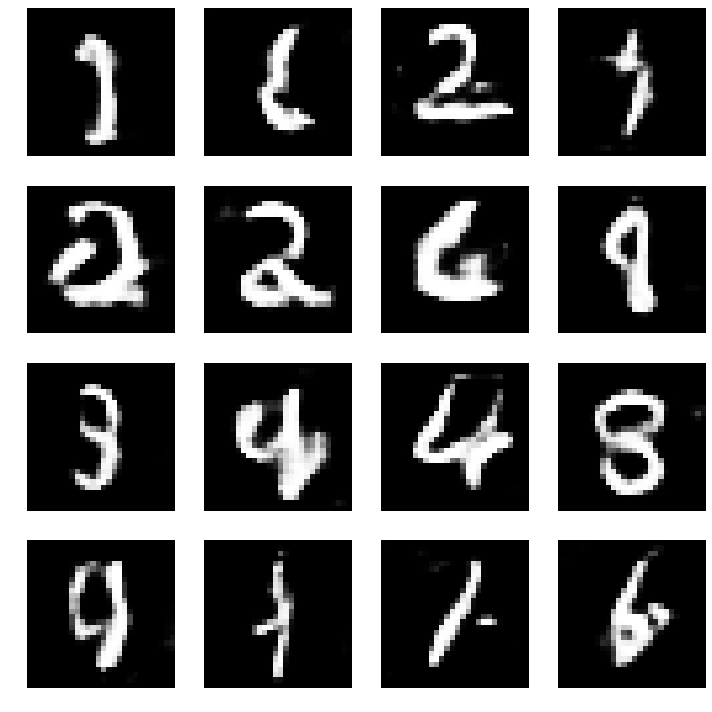

44999: [D loss: 0.597456, acc: 0.714844]  [A loss: 1.528346, acc: 0.226562]


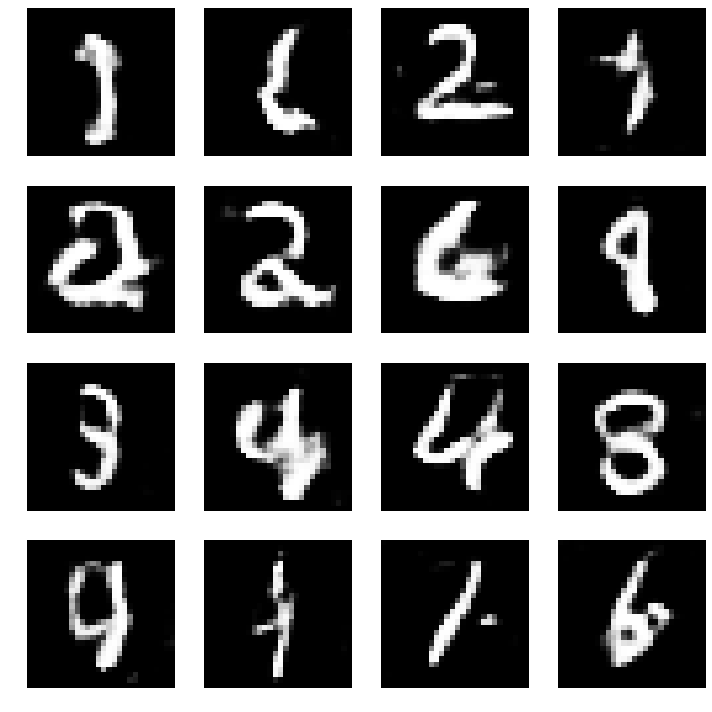

45499: [D loss: 0.497980, acc: 0.761719]  [A loss: 1.445549, acc: 0.226562]


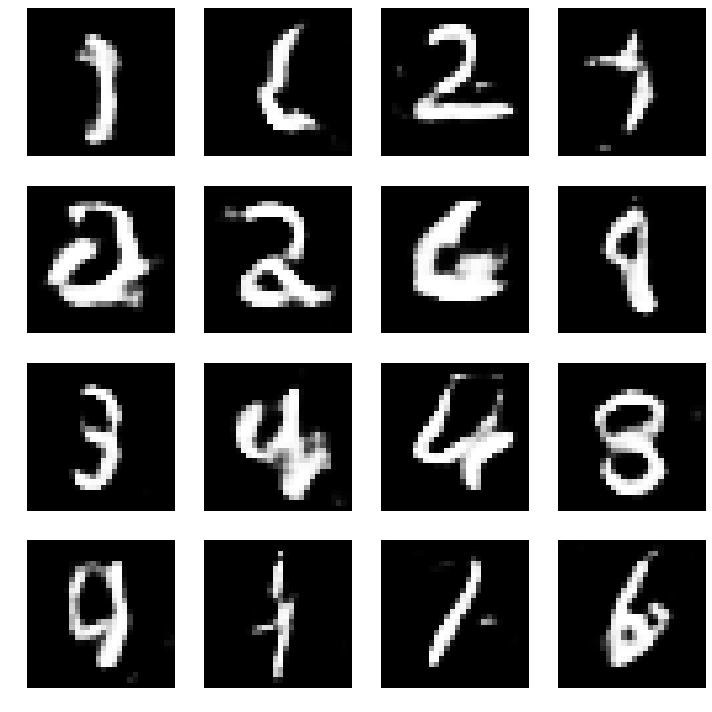

45999: [D loss: 0.558132, acc: 0.738281]  [A loss: 1.439964, acc: 0.195312]


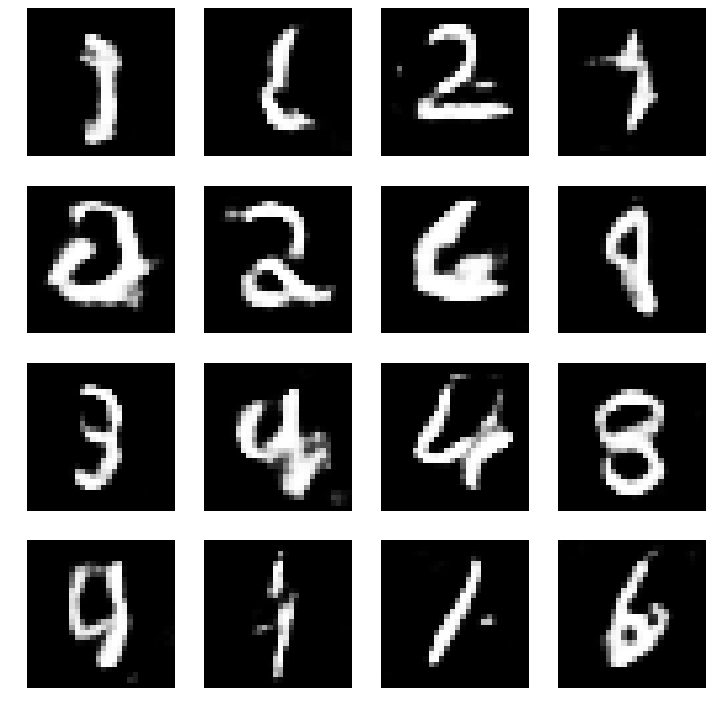

46499: [D loss: 0.531819, acc: 0.757812]  [A loss: 1.488294, acc: 0.203125]


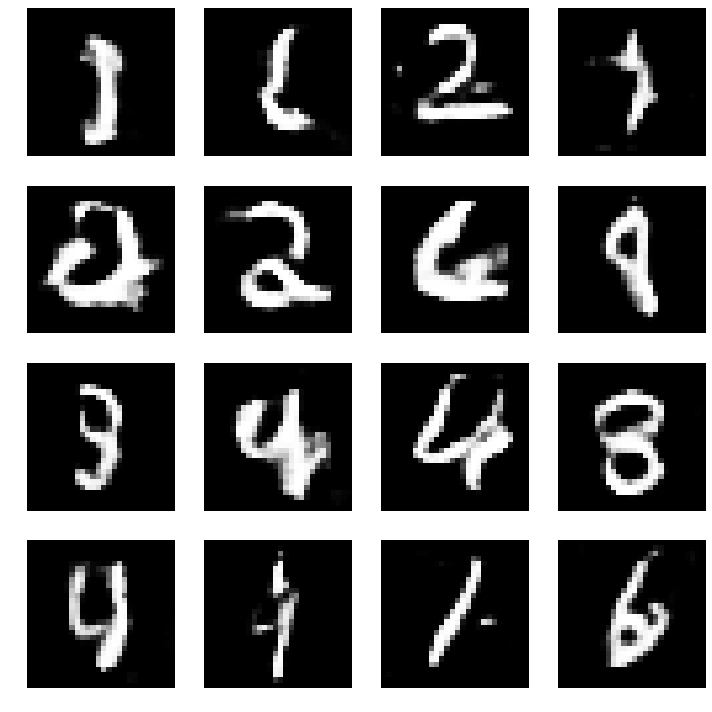

46999: [D loss: 0.506054, acc: 0.750000]  [A loss: 1.483570, acc: 0.179688]


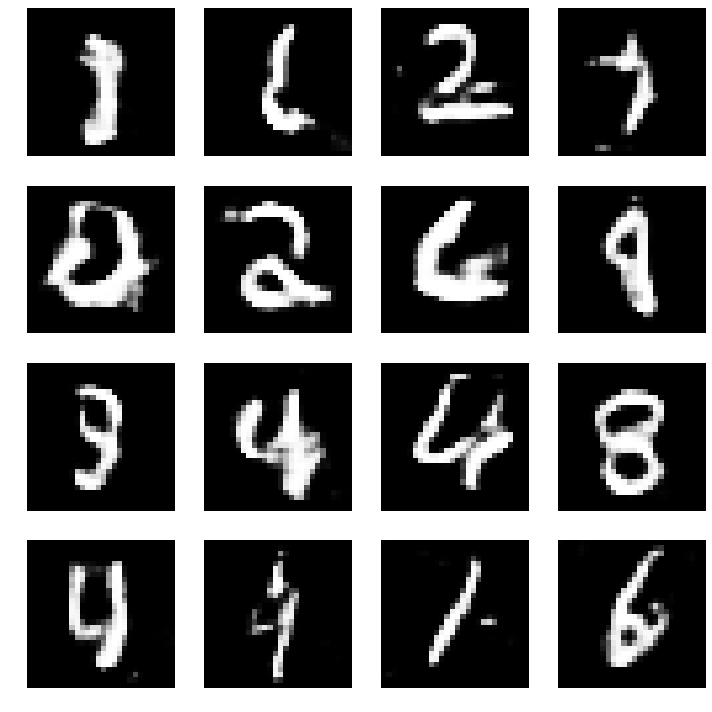

47499: [D loss: 0.459107, acc: 0.796875]  [A loss: 1.513112, acc: 0.171875]


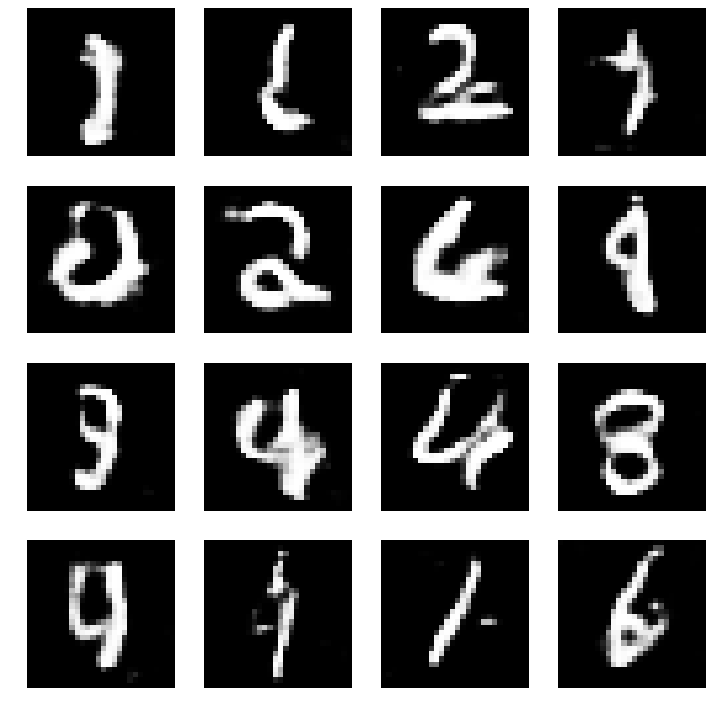

47999: [D loss: 0.639265, acc: 0.628906]  [A loss: 1.346074, acc: 0.273438]


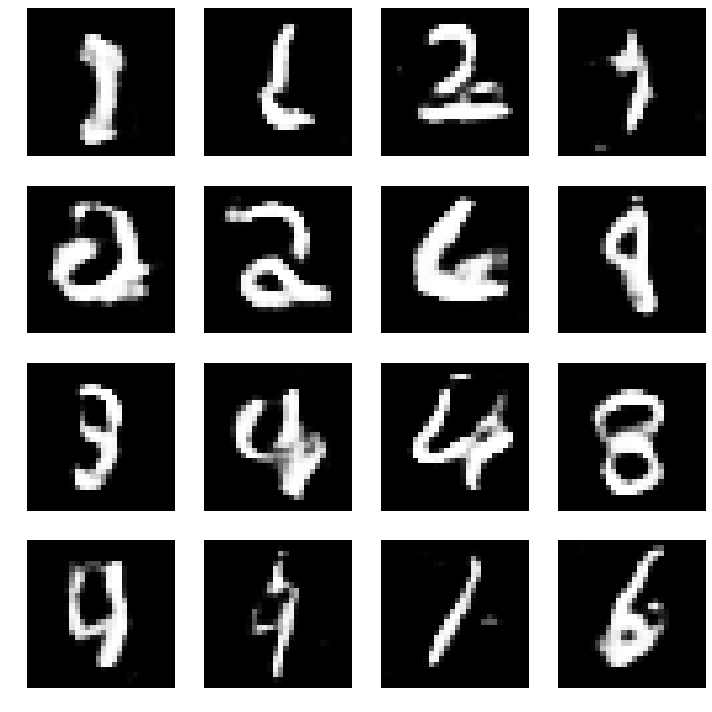

48499: [D loss: 0.559949, acc: 0.718750]  [A loss: 1.446784, acc: 0.210938]


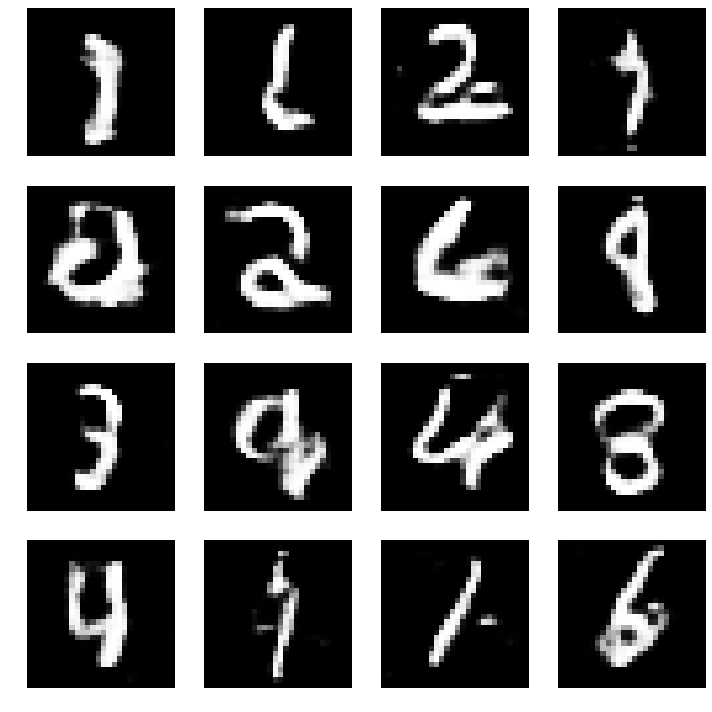

48999: [D loss: 0.514634, acc: 0.750000]  [A loss: 1.394363, acc: 0.226562]


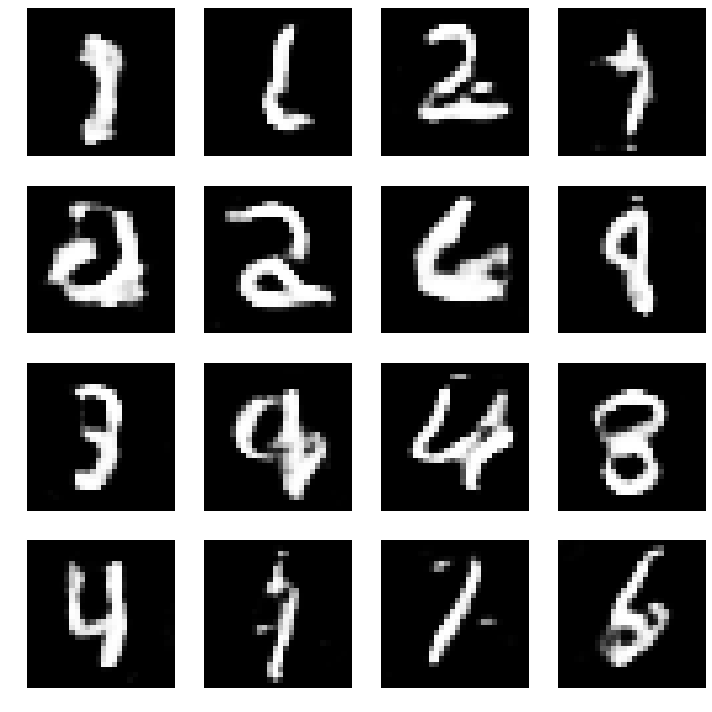

49499: [D loss: 0.607840, acc: 0.695312]  [A loss: 1.415503, acc: 0.179688]


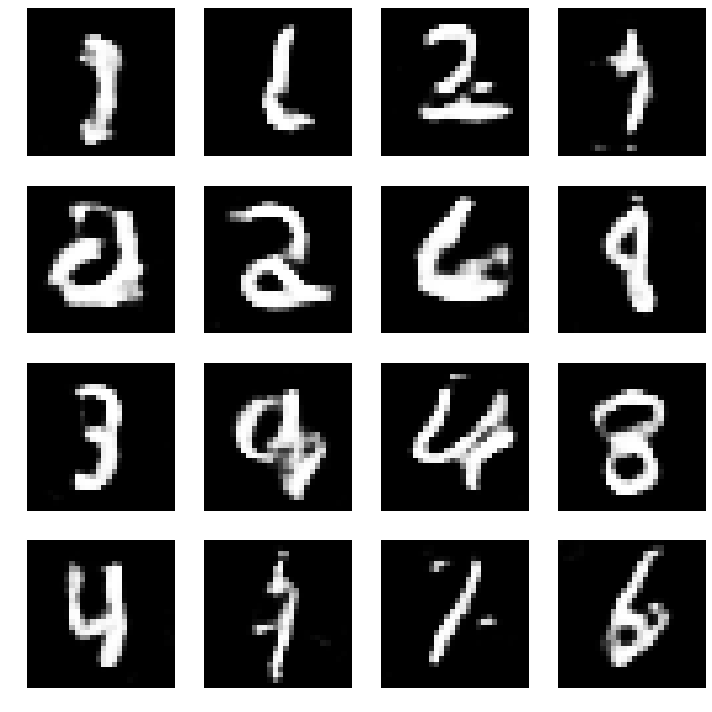

49999: [D loss: 0.534914, acc: 0.738281]  [A loss: 1.350292, acc: 0.250000]


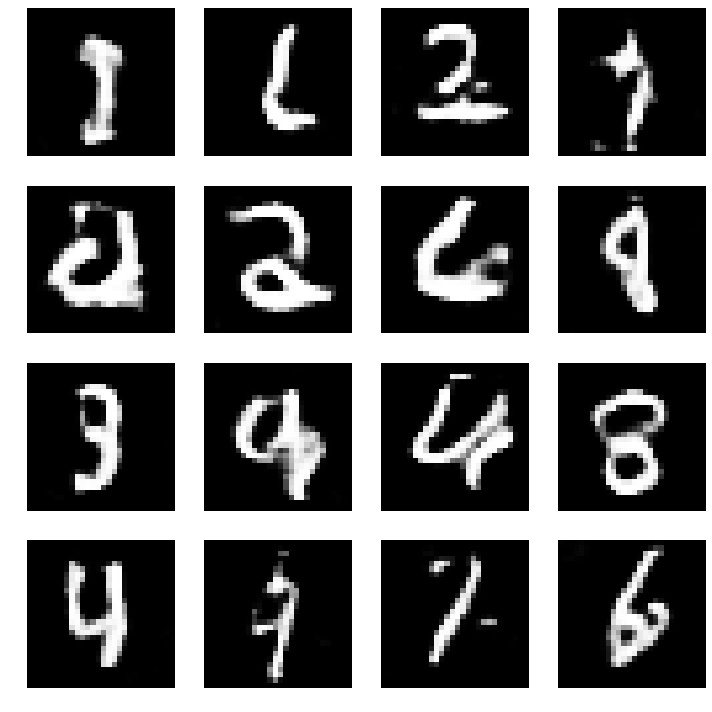

In [18]:
# Static noise to generate the training outup for supervision
noise_output = np.random.uniform(-1.0, 1.0, size=[16, 100])
  
for i in range(train_steps):
  if i % discriminator_training_interval == 0:
    d_loss = train_discriminator(Discriminator, Generator, x_train, batch_size)
  
  if i % generator_training_interval == 0:
    a_loss = train_generator(Adversarial, batch_size)  
  
  if print_output_interval > 0:
    
    if (i+1)%print_output_interval == 0:
      
      log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
      log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
      print(log_mesg)
      
      plot_images(save_img=False,
                  samples=noise_output.shape[0], 
                  noise=noise_output, 
                  step=(i+1))

### Model storage

In [0]:
# Datetime for the filenames
currentDT = str(datetime.datetime.now())

# Storing directory
!mkdir "$currentDT"

D.save(currentDT + '/G ' + currentDT + '.h5')
D.save(currentDT + '/D ' + currentDT + '.h5')
Adversarial.save(currentDT + '/Adversarial ' + currentDT + '.h5')
Discriminator.save(currentDT + '/Discriminator ' + currentDT + '.h5')

plot_images(save_img=True, 
            filename=currentDT + '/generation ' + currentDT + ' ' + str(train_steps) + '.png',
            samples=noise_output.shape[0], 
            noise=noise_output, 
            step=(i+1))

## Result visualization

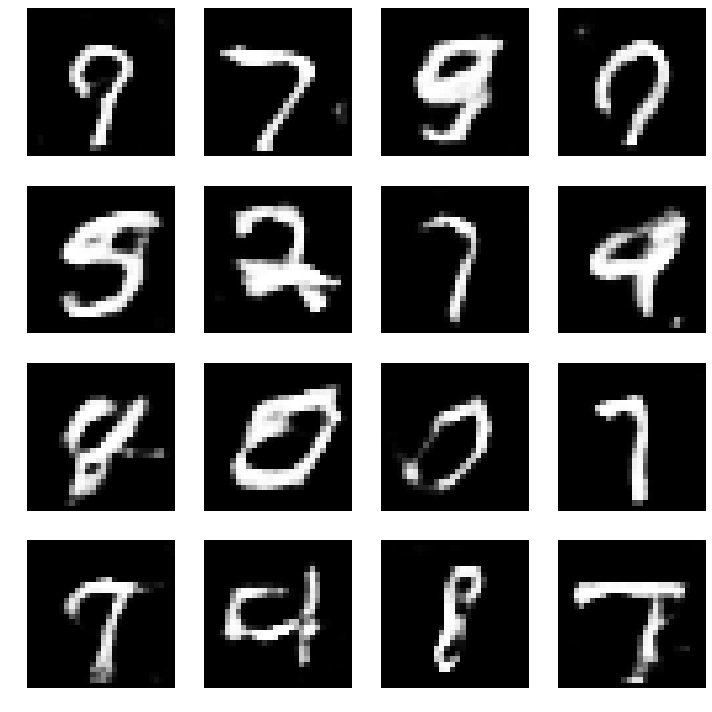

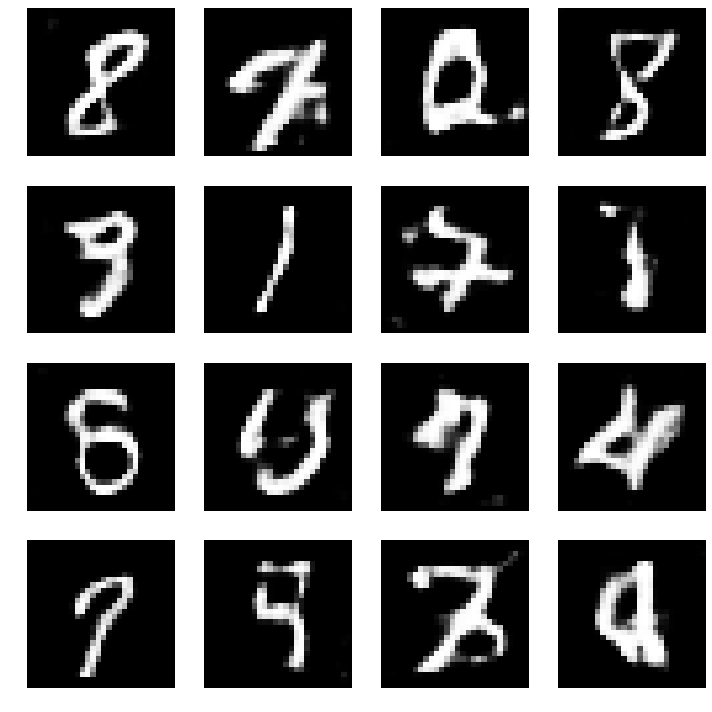

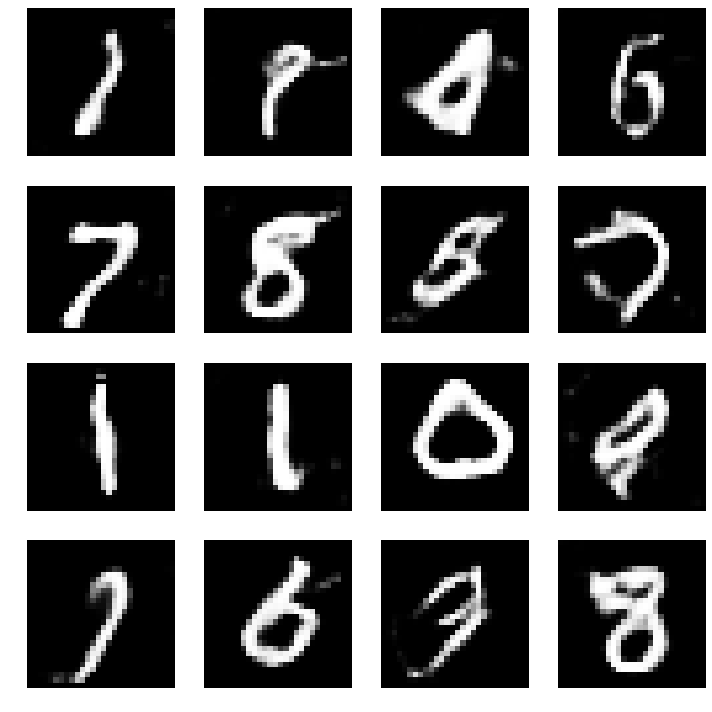

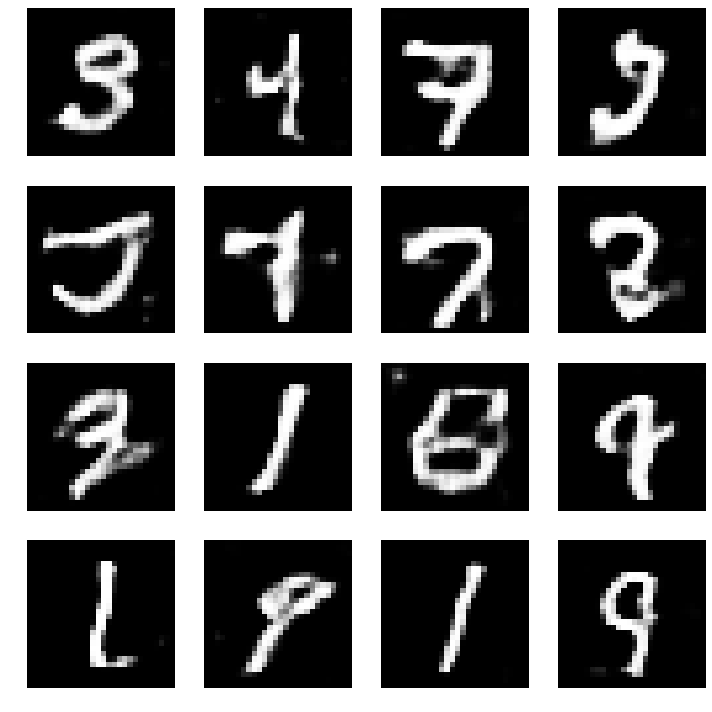

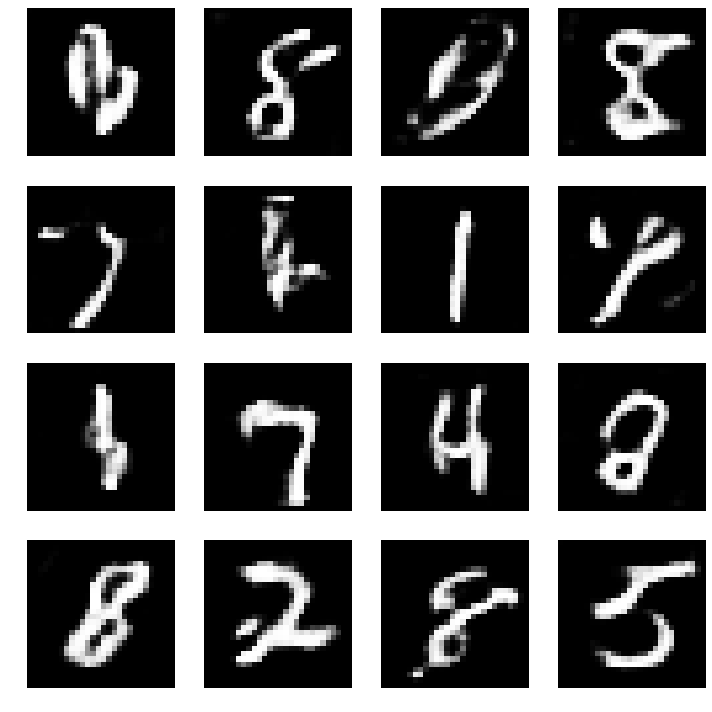

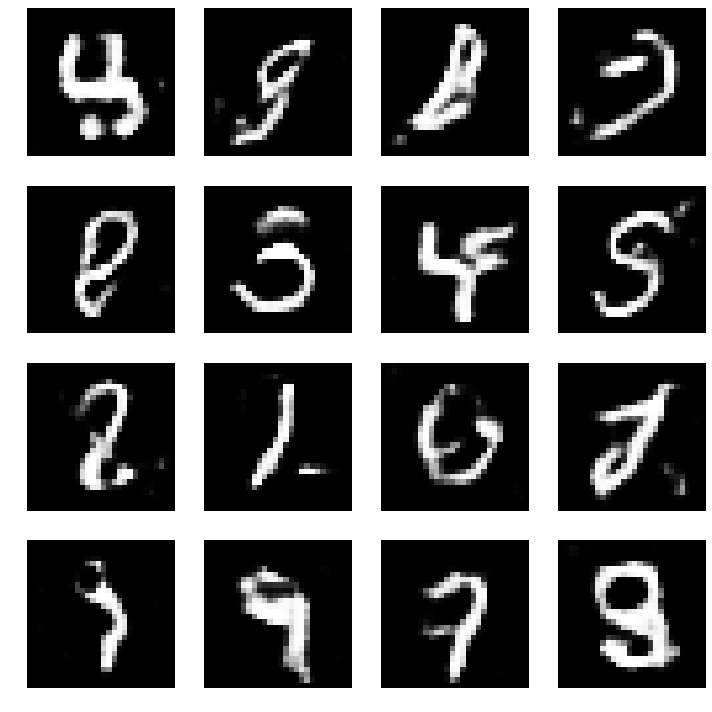

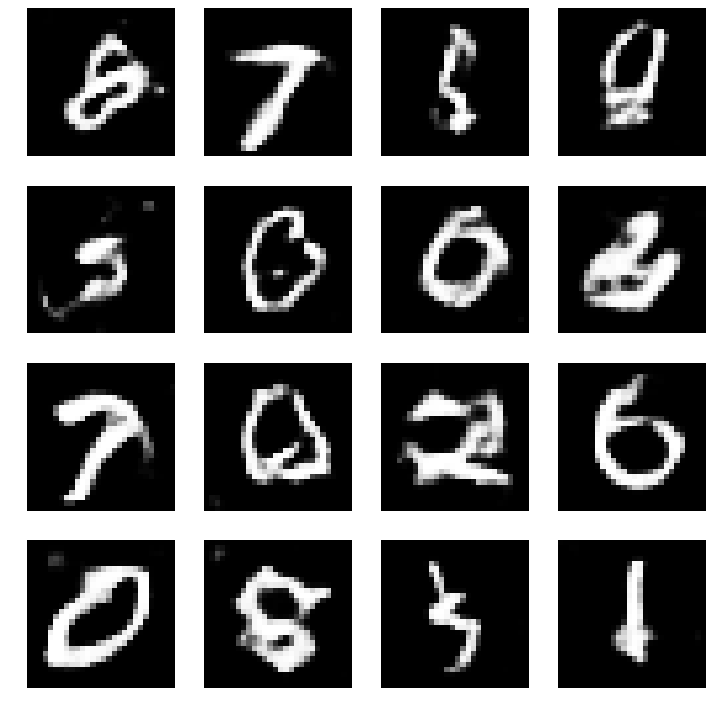

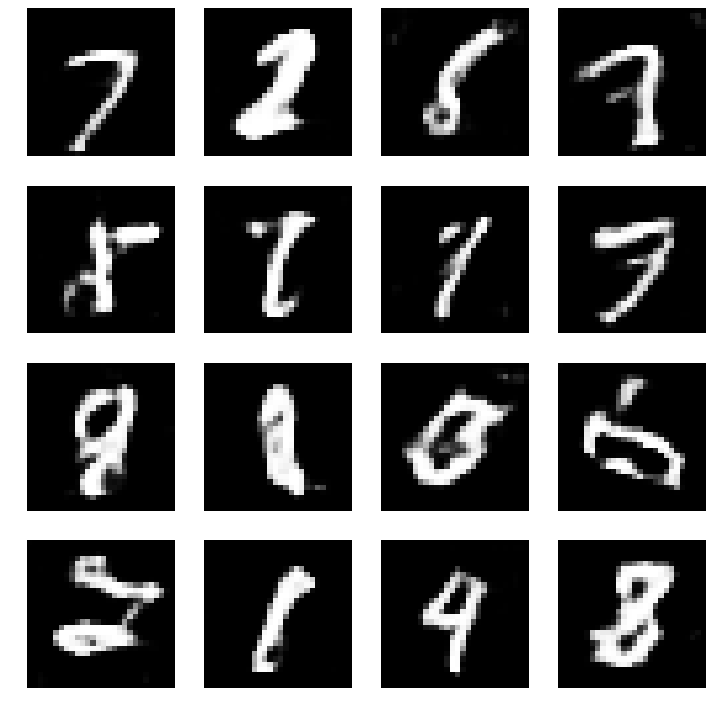

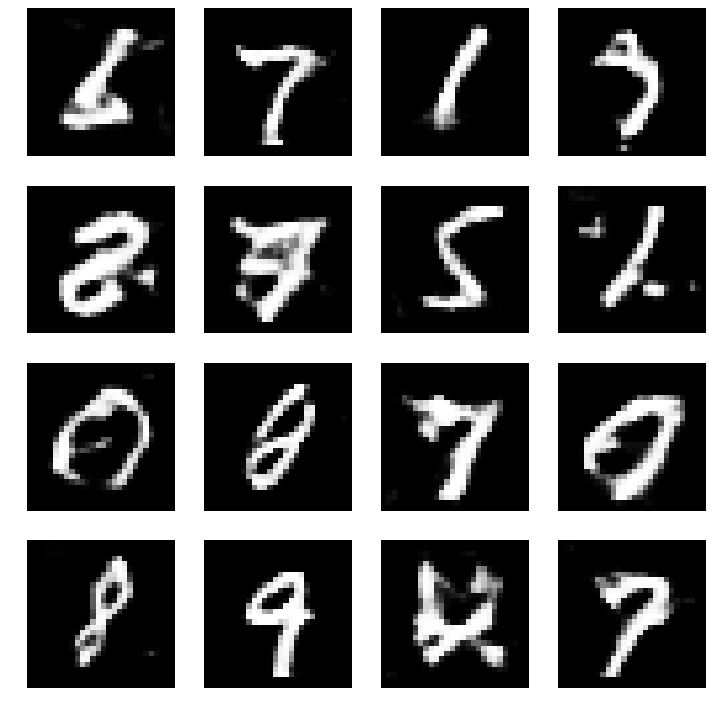

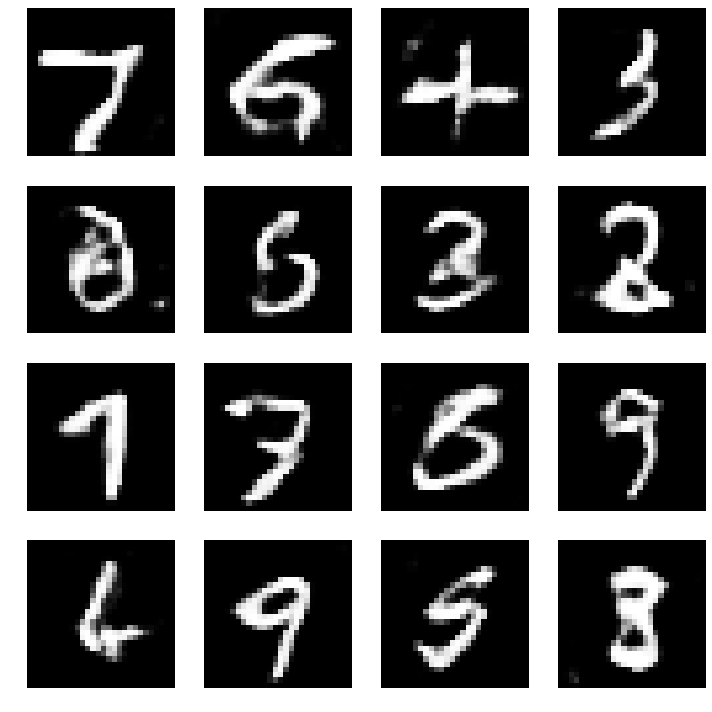

In [20]:
for i in range(10):
  plot_images(save_img=False,
              samples=noise_output.shape[0],
              step=train_steps)
